<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [21]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut,KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [22]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness index': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians (%)': 7,
        'muslims (%)': 8,
        'no religion (%)': 9,
        'buddhists (%)': 10,
        'hindus (%)': 11,
        'jews (%)': 12,
        'other religion (%)': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'post-HS education men (%)': 20,
        'Post-HS education women (%)': 21,
        'human development index': 22,
        'gender inequality index': 23,
        'first marriage age women': 24,
        'first marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortion rate': 29,
        'social media users': 30
    }
    countries_with_data = sorted(list(set([key[0] for key in data.keys() if key[1] == year])))
    index = pd.MultiIndex.from_product([countries_with_data, [year]], names=['country', 'year'])
    df = pd.DataFrame(index=index, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for (country, yr) in index:
        key = (country, yr)
        features = data[key][1]
        target.append(data[key][0])
        for feature_name, feature_index in feature_map.items():
            if feature_index < len(features):
              df.loc[key, feature_name] = features[feature_index]
              if str(features[feature_index]) =='nan':
                df.loc[key, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 2 years
    for i in range(1, 3):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 2 years, linearly extrapulate from last 6 years
    recent_years_data = []
    for i in range(6,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        last_value = values[-1]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c

            # Check if extrapolated value is within 50% of last value
            if last_value != 0 and abs(extrapolated_value - last_value) / abs(last_value) > 0.3:
                return last_value
            elif last_value == 0 and abs(extrapolated_value) > 0.3 * np.mean(values): # Handle edge case where last_value is 0
                 return last_value
            else:
                return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return last_value # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [23]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(str(country))

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process all the data:
add some missing data, split to train and test and normalize

In [24]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortion rate': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gender inequality index':{
            'Central African Republic':0.682
        },
        'physicians per capita':{
            'Somalia': 0.048, 'Viet Nam': 1.25
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if (country,2023) in df_features.index:
                df_features.loc[(country,2023), feature] = value

    # Convert all columns to numeric, coercing errors
    df_features = df_features.apply(pd.to_numeric, errors='coerce')

    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def process_multi_year_data(data_output):
  years = [2013, 2003, 1993]
  all_features = []
  all_targets = []

  for year in years:
      df_features, target = calc_features_year(data, year)
      all_features.append(df_features)
      all_targets.extend(target)

  X = pd.concat(all_features)
  y = pd.Series(all_targets, index=X.index, name='target')

  columns_to_drop = [
      'christians (%)', 'muslims (%)', 'no religion (%)', 'buddhists (%)',
      'hindus (%)', 'jews (%)', 'other religion (%)', 'gender inequality index',
      'happiness index', 'first marriage age women', 'first marriage age men',
      'work hours men', 'work hours women', 'social media users', 'abortion rate',
      'health expenditure' ,'maternity leave index'
  ]

  X = X.drop(columns=columns_to_drop)
  X = X.apply(pd.to_numeric, errors='coerce')

  # Add specific missing data points (structured by feature)
  missing_values_to_fill_manual = {
      'GNI PPP': {
          ('Venezuela, RB', 2023): 20017,
          ('Syrian Arab Republic', 2007): 3914.3,
          ('Nigeria', 2007): 3260.8,
          ('Afghanistan', 1991): 1070
      },
      'female labor participation': {
          ('Grenada', 2023): 51.42
      },
      'physicians per capita': {
          ('Hong Kong SAR, China', 2023): 2.1,
          ('Hong Kong SAR, China', 2007): 1.13,
          ('India', 2007): 0.61
      },
      'urbanization': {
          ('West Bank and Gaza', 2023): 77.58,
          ('West Bank and Gaza', 2007): 73.49,
          ('South Sudan', 2023): 21.56,
          ('Montenegro', 2023): 68.5,
          ('Montenegro', 2007): 63.14,
          ('Maldives', 2023): 42.41,
          ('Maldives', 2007): 35.2,
          ('Serbia', 2023): 57.11,
          ('Serbia', 2007): 54.33
      },
      'human development index': {
          ('Sudan', 2007): 0.526,
          ('Rwanda', 1991): 0.213,
          ('Sao Tome and Principe', 1991): 0.399,
          ('Liberia', 1991): 0.22,
          ('Ethiopia', 1991): 0.166
      }
  }

  for feature, country_year_values in missing_values_to_fill_manual.items():
      if feature in X.columns:
          for (country, year), value in country_year_values.items():
              if (country, year) in X.index:
                  X.loc[(country, year), feature] = value

  combined_df = pd.concat([X, y], axis=1)
  combined_df_cleaned = combined_df.dropna()

  # Separate features and target again
  X = combined_df_cleaned.drop('target', axis=1)
  y = combined_df_cleaned['target']

  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
  return train_X, test_X, train_y, test_y

In [25]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 5
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

pipeline classes to prepare data

In [26]:
class Scaling2023(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['no religion (%)','other religion (%)','buddhists (%)','hindus (%)','jews (%)','GNI PPP']
        self.health_features=health_features or ['physicians per capita','health expenditure']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','happiness index','GNI PPP','female labor participation','christians (%)','muslims (%)','no religion (%)',
            'buddhists (%)','hindus (%)','jews (%)','other religion (%)','post-HS education men (%)','post-HS education men (%)',
            'human development index','gender inequality index','first marriage age women','first marriage age men','maternity leave index',
            'work hours men','work hours women','abortion rate','social media users','healthcare index score'
        ]
        self.health_scaler=StandardScaler()
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        missing=[c for c in (self.health_features+self.log_features) if c not in X_copy.columns]
        if missing: raise KeyError(f"Missing columns: {missing}")

        self.health_scaler.fit(X_copy[self.health_features])
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

class ScalingMultiYear(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None):
        self.log_features=log_features or ['GNI PPP','physicians per capita']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','GNI PPP',
            'female labor participation','post-HS education men (%)',
            'post-HS education men (%)','human development index',
            'physicians per capita'
        ]
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [27]:
def create_health_index_score(X_train,X_test):
    scaler_healthcare = StandardScaler()
    health_features = ['physicians per capita','health expenditure']
    X_train[health_features] = scaler_healthcare.fit_transform(X_train[health_features])
    X_test[health_features] = scaler_healthcare.transform(X_test[health_features])
    X_train['healthcare index score'] = X_train['physicians per capita'] + X_train['health expenditure']
    X_test['healthcare index score'] = X_test['physicians per capita'] + X_test['health expenditure']
    X_train = X_train.drop(['physicians per capita', 'health expenditure'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure'], axis=1)
    return X_train,X_test

In [28]:
def feature_correlations(df, method):
    """Calculates and visualizes correlation matrix, and prints top 5 correlated pairs."""

    correlation_matrix = df.corr(method=method)

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap of Features in X_train')
    plt.show()

    print(f"\nTop 5 most highly correlated pairs of features (absolute {method.capitalize()} correlation):")
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    stacked_corr = upper_tri.stack().sort_values(ascending=False, key=abs)
    top_5_correlated_pairs = stacked_corr.head(5)

    if top_5_correlated_pairs.empty:
        print("No correlated pairs found.")
    else:
        for (feature1, feature2), correlation in top_5_correlated_pairs.items():
            print(f"  {feature1} and {feature2}: {correlation:.4f}")


In [29]:
def analyze_target_correlation(X, y, method_name):
    combined_data = pd.concat([X, y], axis=1)
    correlation_series = combined_data.corr(method=method_name)['target'].drop('target').sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')
    plt.title(f'{method_name} Correlation of Features with Target Variable')
    plt.xlabel(f'{method_name} Correlation Coefficient')
    plt.ylabel('Features')
    plt.show()

    print(f"\n{method_name} Correlation with Target:")
    print(correlation_series)


In [30]:
def analyze_mutual_information(X, y):
    """Calculates and displays Mutual Information scores of features with the target."""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Mutual Information Scores of Features with Target Variable:")
    print(mi_scores)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
    plt.title('Mutual Information Scores of Features with Target Variable')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [43]:
def gridsearch_loocv_lasso(X,y,scaler):
    pipe=Pipeline([('scaler',scaler),('lasso',Lasso())])
    param_grid={'lasso__alpha':[val*(10**i) for i in range(-3,3) for val in [1,3]]}
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_ridge_loocv(X,y,scaler):
    pipe=Pipeline([('scaler',scaler),('ridge',Ridge())])
    param_grid={
        'ridge__alpha':[val*(10**i) for i in range(-3,3) for val in [1,3]]
    }
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_random_forest(X,y,scaler):
  pipe=Pipeline([('scaler',scaler),('rf',RandomForestRegressor(random_state=42,n_jobs=-1))])
  kf=KFold(n_splits=5,shuffle=True,random_state=42)
  param_grid = {
        'rf__n_estimators': [10, 25, 100, 400],
        'rf__max_depth': [1, 2, 3, 4],
        'rf__min_samples_split': [2, 3 , 5, 9],
        'rf__min_samples_leaf': [1, 2, 4, 6],
        'rf__max_features': ['sqrt', 0.5, 1.0],
    }
  gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
  gs.fit(X,y)
  return gs


def gridsearch_xgboost(X, y,scaler):
    pipe = Pipeline([
        ('scaler', scaler),
        ('xgb', XGBRegressor(tree_method='hist',random_state=42,n_jobs=-1,importance_type='gain'))])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'xgb__n_estimators': [10, 25, 100, 400],
        'xgb__learning_rate': [0.001, 0.01 , 0.1,0.5],
        'xgb__max_depth': [1, 2, 4],
        'xgb__min_child_weight': [1, 10],
        'xgb__subsample': [0.7],#decrease overfit
        'xgb__colsample_bytree': [0.7],#decrease overfit
        'xgb__gamma': [0, 1],
        'xgb__reg_alpha': [0, 1],
        'xgb__reg_lambda': [1,10],

    }
    gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

import pandas as pd

def report_grid_search(gs,X,y,model,scaler):
  best_est = gs.best_estimator_
  names = best_est.named_steps['scaler'].transform(X).columns
  idx = gs.best_index_
  cv_mse = -gs.cv_results_['mean_test_score'][idx]
  print(f"Best params: {gs.best_params_}")
  print(f"CV MSE: {cv_mse:.4f} (±{gs.cv_results_['std_test_score'][idx]:.4f})")
  print("Train accuracy:")
  accuracy_report(best_est,X,y)
  est = best_est.named_steps[model]

  if model in ['lasso','ridge']:
    coefs = pd.Series(est.coef_, index=names)
    coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    print("\ncoefficients:")
    for f,c in coefs.items():
      print(f"{f}: {c:.4f}")
  else:#random forrest or xgboost
    if model=='rf':
      print("\nmean decrease in imputirty by feature:")
    if model=='xgb':
      print("\nmean gain by feature:")
    imp = pd.Series(est.feature_importances_, index=names).sort_values(ascending=False)
    for f,v in imp.items():
      print(f"{f}: {v:.4f}")

In [32]:
def accuracy_report(estimator,X,y):
  y_pred=estimator.predict(X)
  mse=mean_squared_error(y,y_pred)
  print(f"MSE: {mse:.4f}")

In [33]:
def exec_experiments(data,isMultiYear):
  if isMultiYear:
    X_train,X_test,y_train,y_test = process_multi_year_data(data)
    scaler = ScalingMultiYear()
    unscaled_X_train=X_train.copy()
    unscaled_X_test=X_test.copy()
  else:#is only 2023
    X_train, X_test, y_train, y_test = process_2023_data(data)
    unscaled_X_train,unscaled_X_test = create_health_index_score(X_train.copy(),X_test.copy())
    scaler = Scaling2023()

  print('unscaled features')
  plot_features(unscaled_X_train)
  scaler.fit(X_train)
  scaled_train = scaler.transform(X_train)
  scaled_test = scaler.transform(X_test)
  print('scaled features')
  plot_features(scaled_train)

  #feature pairs correlations
  print('\nfeature pairs correlations:')
  feature_correlations(scaled_train, 'pearson')
  feature_correlations(scaled_train, 'spearman')
  #feature-target correlations and mutual information
  analyze_target_correlation(scaled_train, y_train, 'pearson')
  analyze_target_correlation(scaled_train, y_train, 'spearman')
  analyze_mutual_information(scaled_train, y_train)
  #linear regressor models
  print('\nlasso regressor:')
  lasso_gs = gridsearch_loocv_lasso(X_train,y_train, scaler)
  report_grid_search(lasso_gs,X_train,y_train,'lasso', scaler)
  print('\nridge regressor:')
  ridge_gs = gridsearch_ridge_loocv(X_train,y_train, scaler)
  report_grid_search(ridge_gs,X_train,y_train,'ridge', scaler)
  #random forest regressor model
  print('\nrandom forest regressor:')
  rf_gs = gridsearch_random_forest(X_train,y_train, scaler)
  report_grid_search(rf_gs,X_train,y_train,'rf', scaler)
  #xgboost regressor model
  print('\nxgboost regressor:')
  xgb_gs = gridsearch_xgboost(X_train,y_train, scaler)
  report_grid_search(xgb_gs,X_train,y_train,'xgb', scaler)

  #correlations\MI:
  print("testing single feature relations test set:")
  analyze_target_correlation(scaled_test, y_test, 'pearson')
  analyze_target_correlation(scaled_test, y_test, 'spearman')
  analyze_mutual_information(scaled_test, y_test)

  # Calculate and print train\test MSE for each model
  print('\nlasso regressor final results:')
  accuracy_report(lasso_gs.best_estimator_,X_test,y_test)
  print('\nridge regressor final results:')
  accuracy_report(ridge_gs.best_estimator_,X_test,y_test)
  print('\nrandom forest regressor final results:')
  accuracy_report(rf_gs.best_estimator_,X_test,y_test)
  print('\nxgboost regressor final results:')
  accuracy_report(xgb_gs.best_estimator_,X_test,y_test)

  return X_train, X_test, y_train, y_test, lasso_gs, ridge_gs, rf_gs, xgb_gs

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

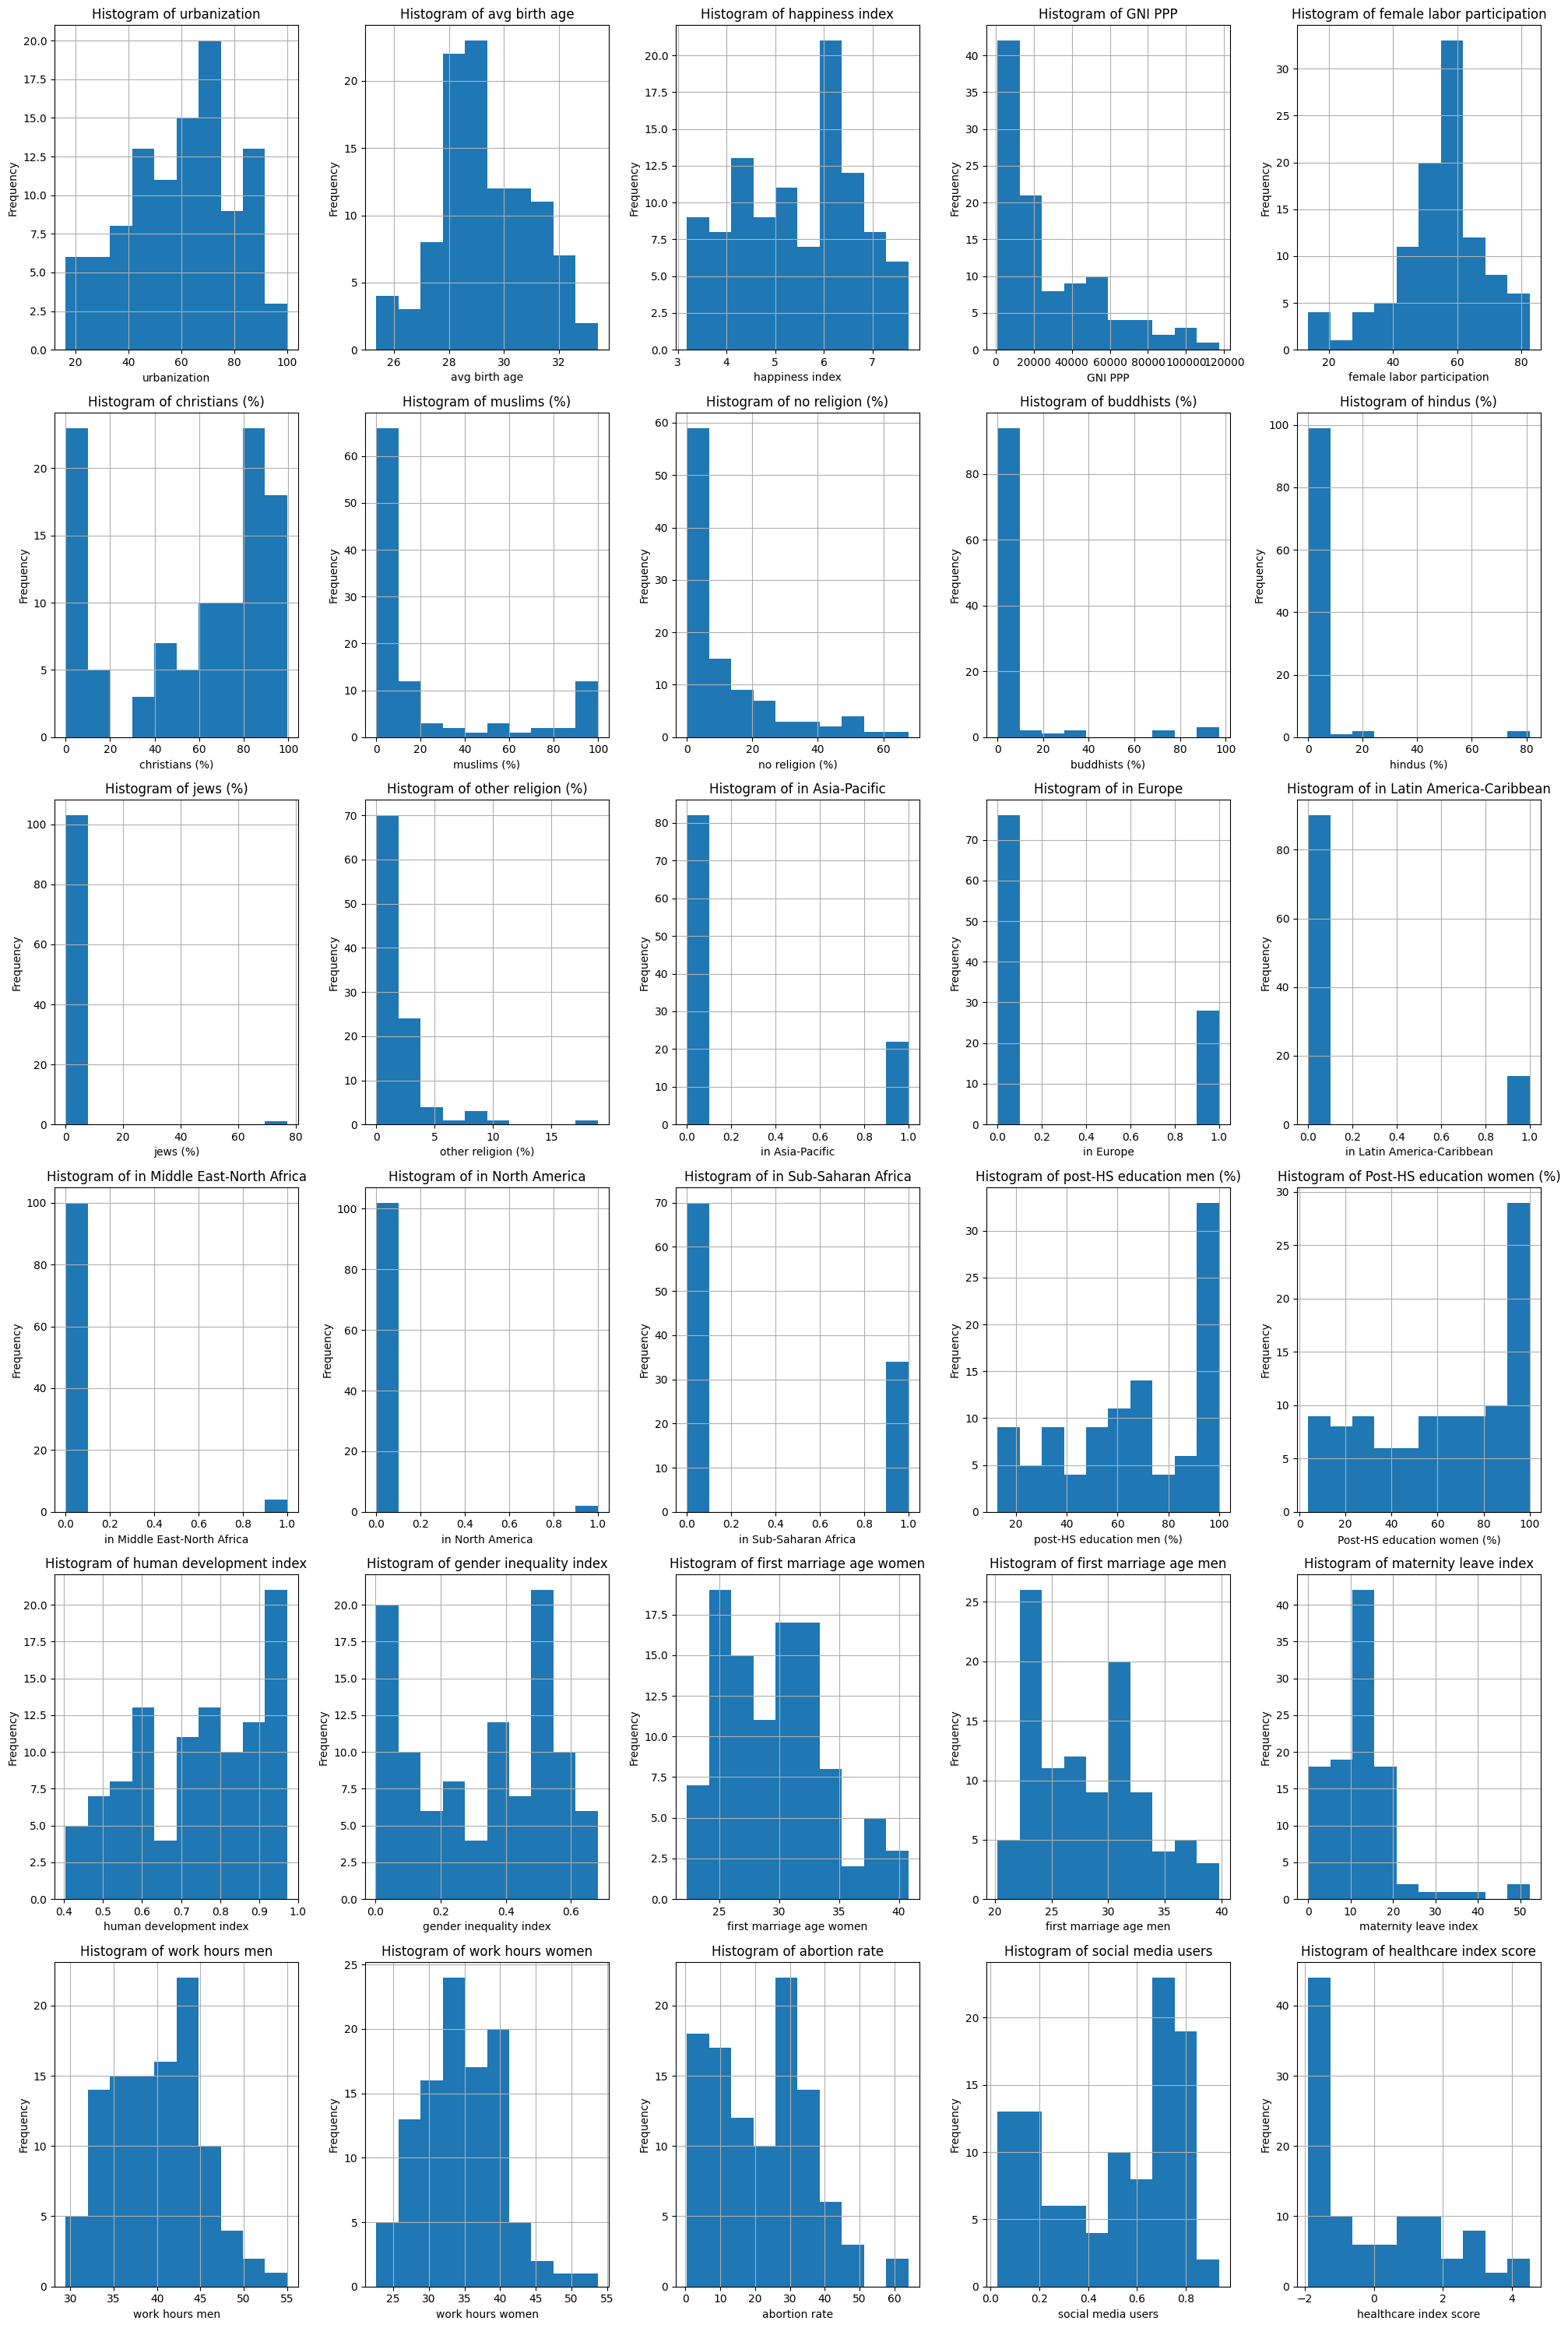

scaled features


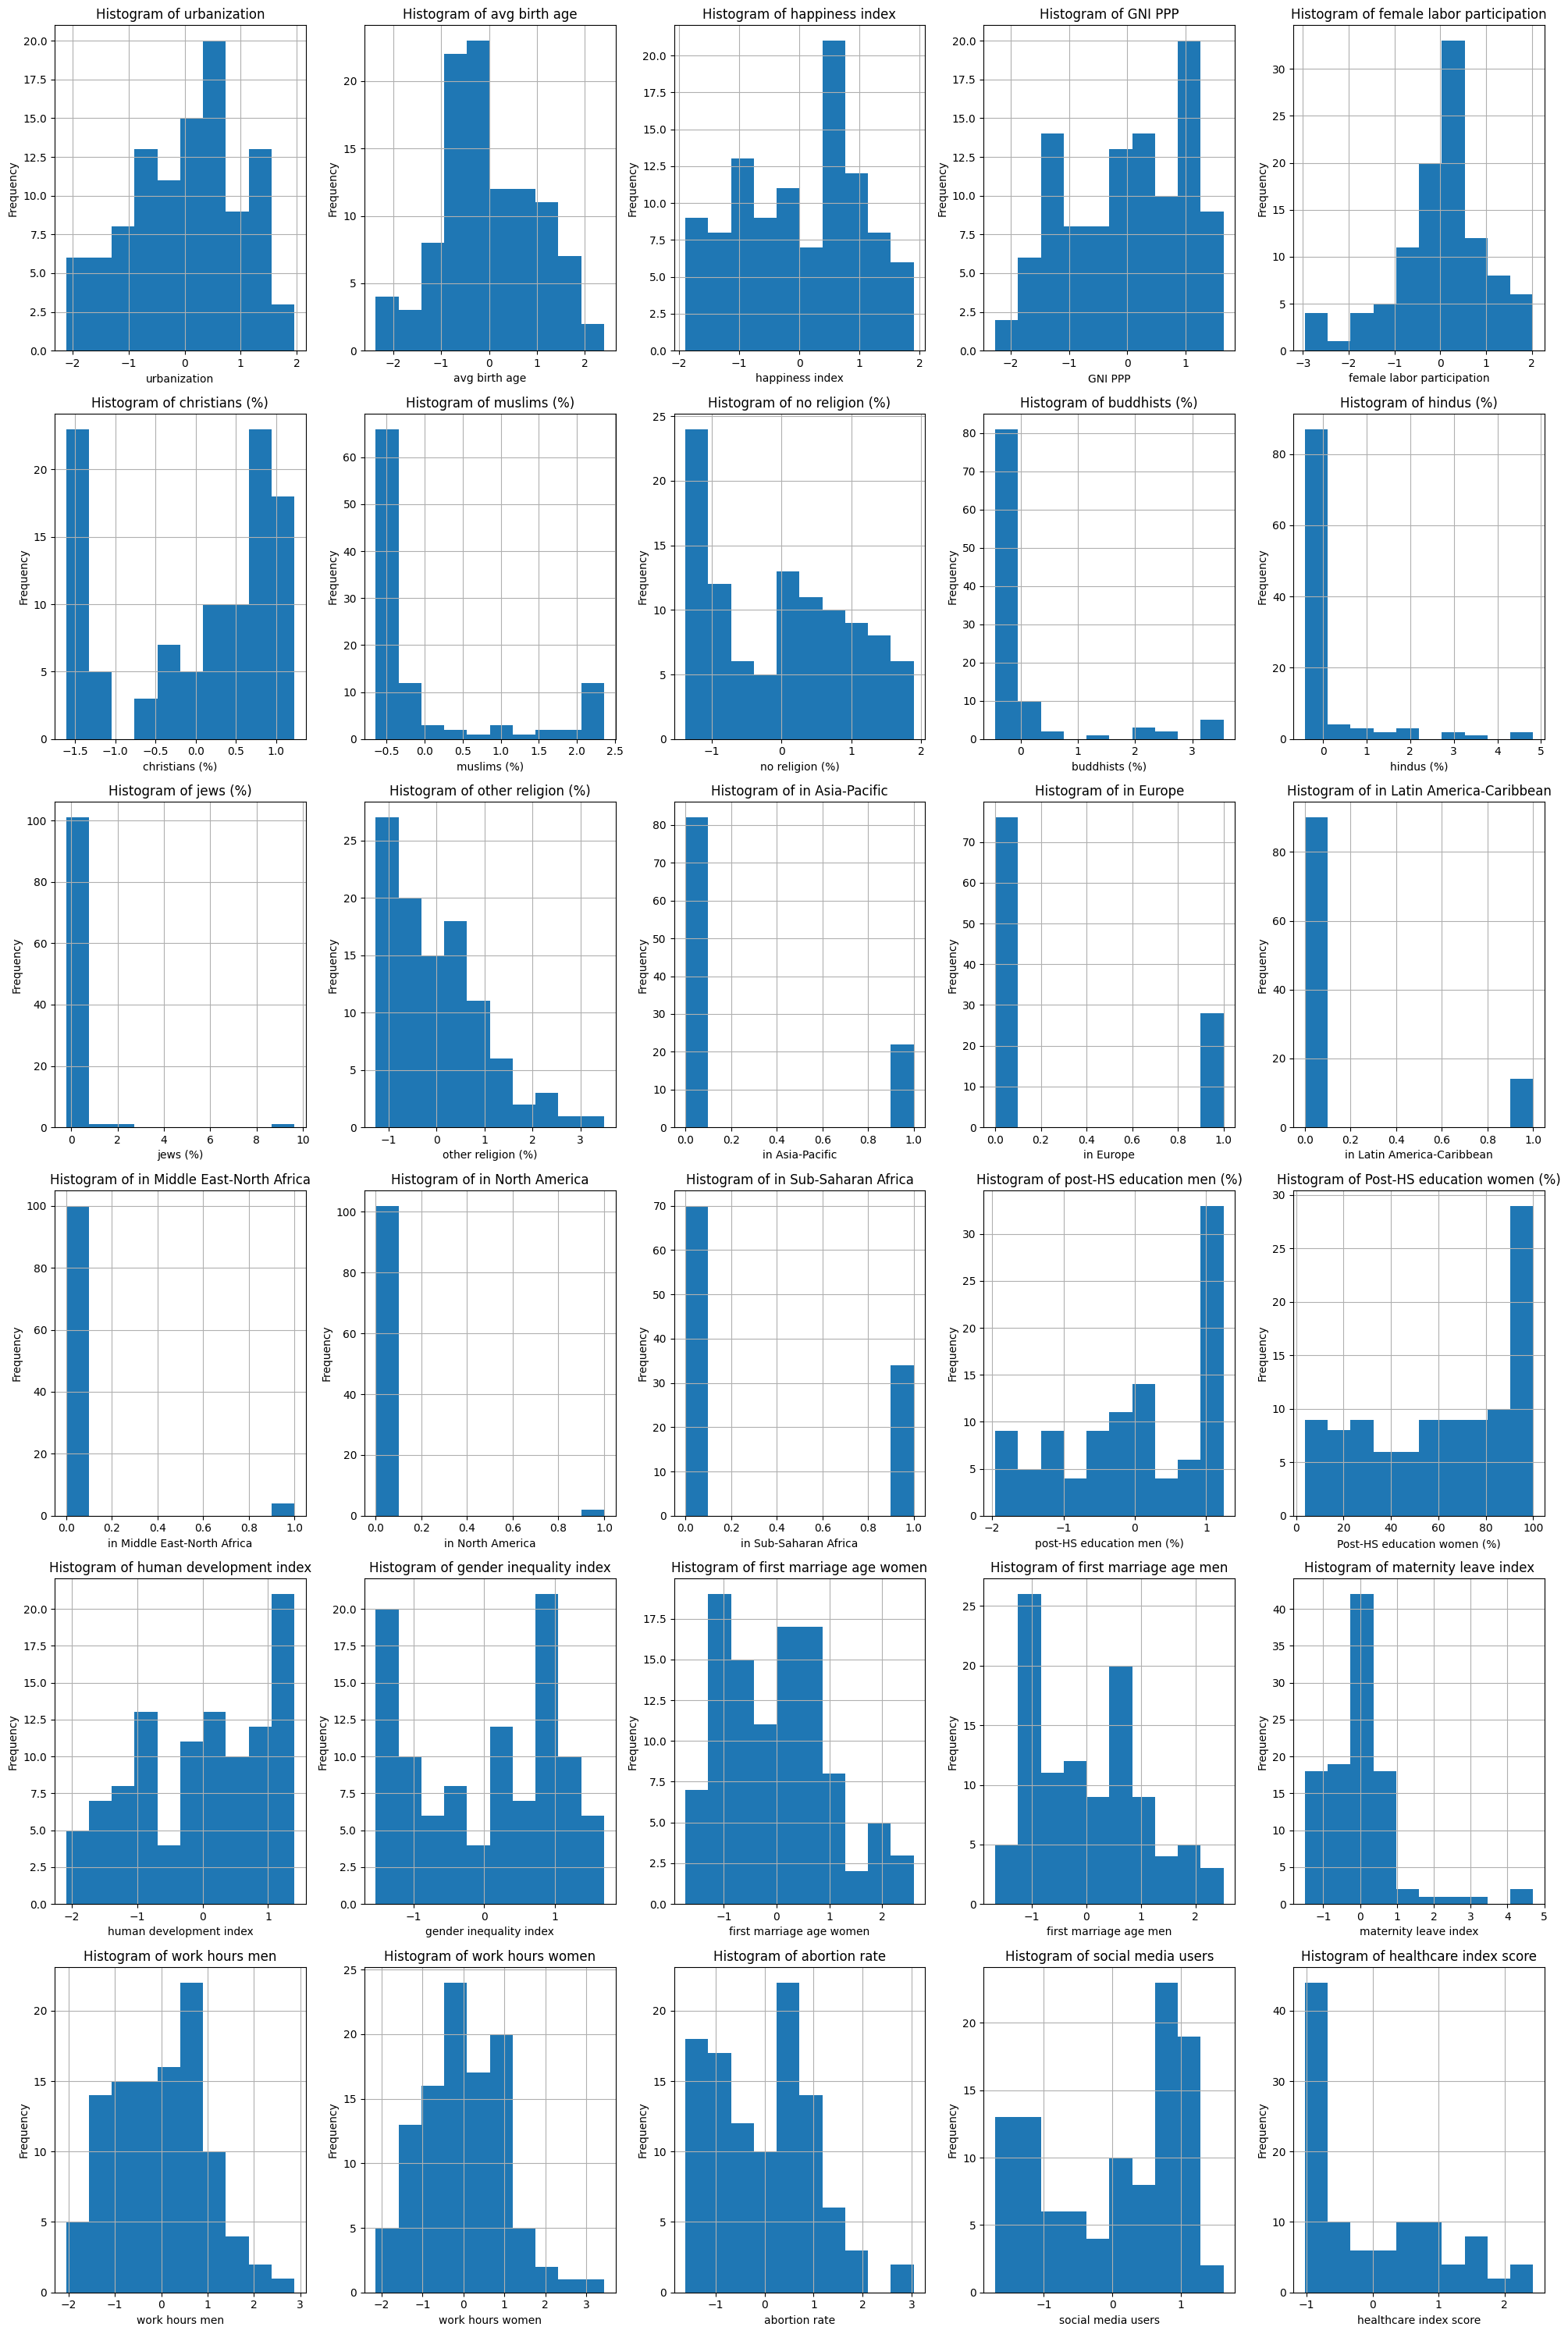


feature pairs correlations:


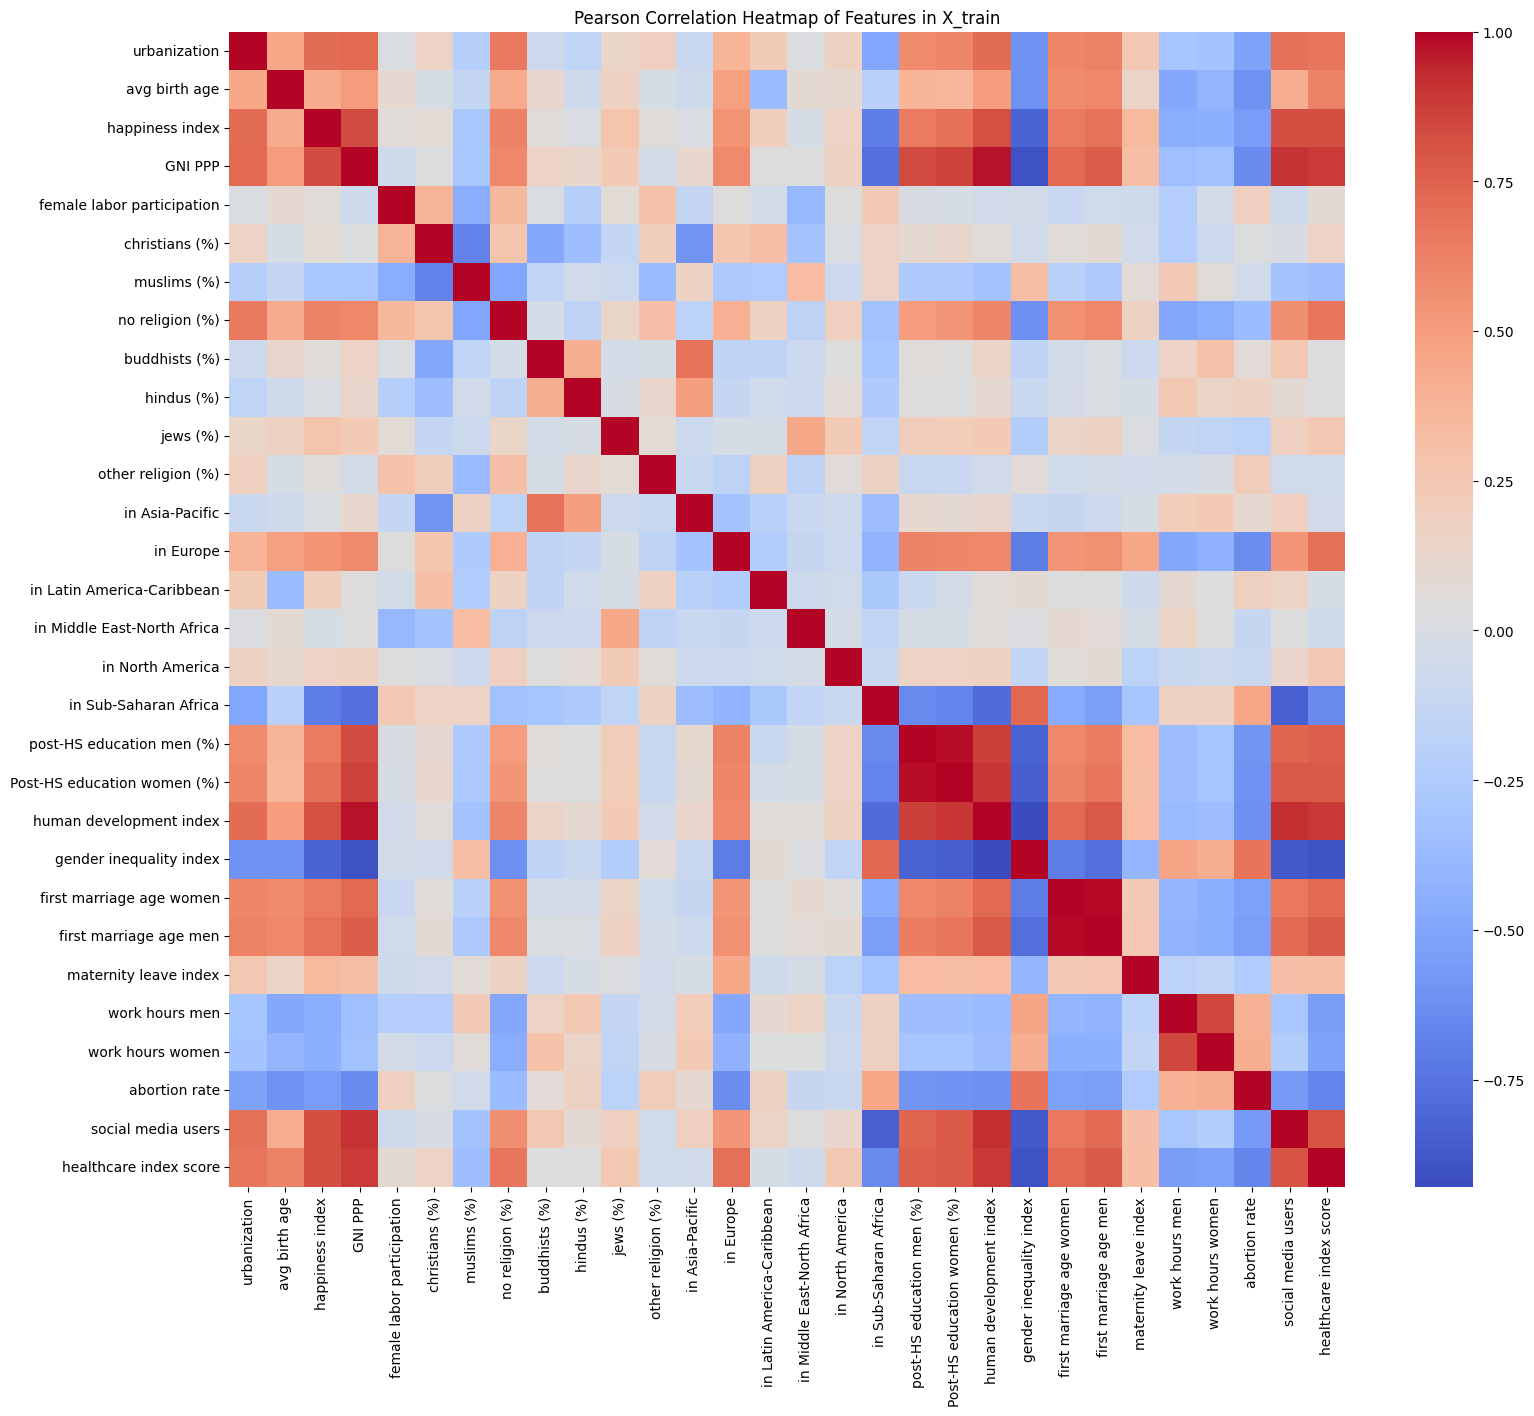


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  first marriage age women and first marriage age men: 0.9888
  post-HS education men (%) and Post-HS education women (%): 0.9811
  GNI PPP and human development index: 0.9754
  human development index and gender inequality index: -0.9283
  human development index and social media users: 0.9166


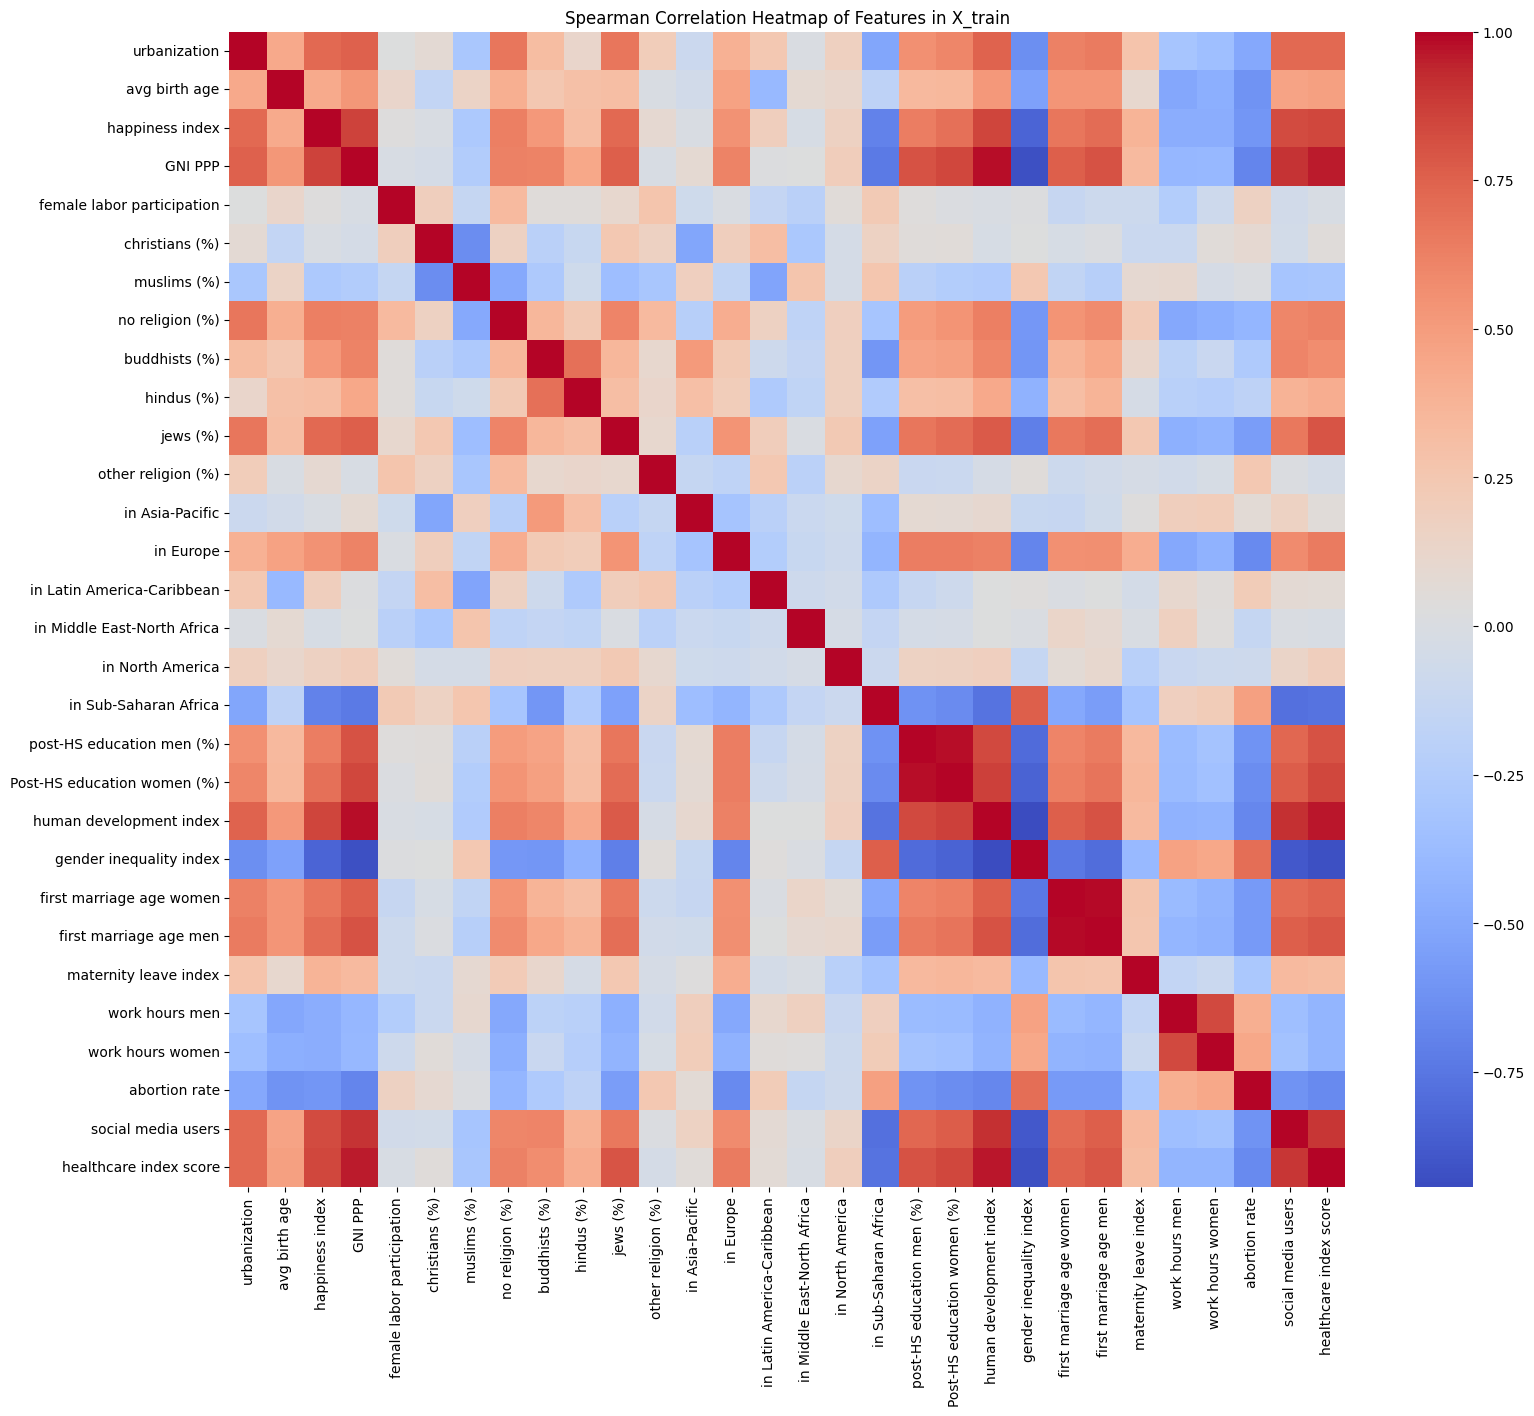


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  first marriage age women and first marriage age men: 0.9851
  post-HS education men (%) and Post-HS education women (%): 0.9822
  GNI PPP and human development index: 0.9821
  human development index and healthcare index score: 0.9683
  GNI PPP and healthcare index score: 0.9578


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


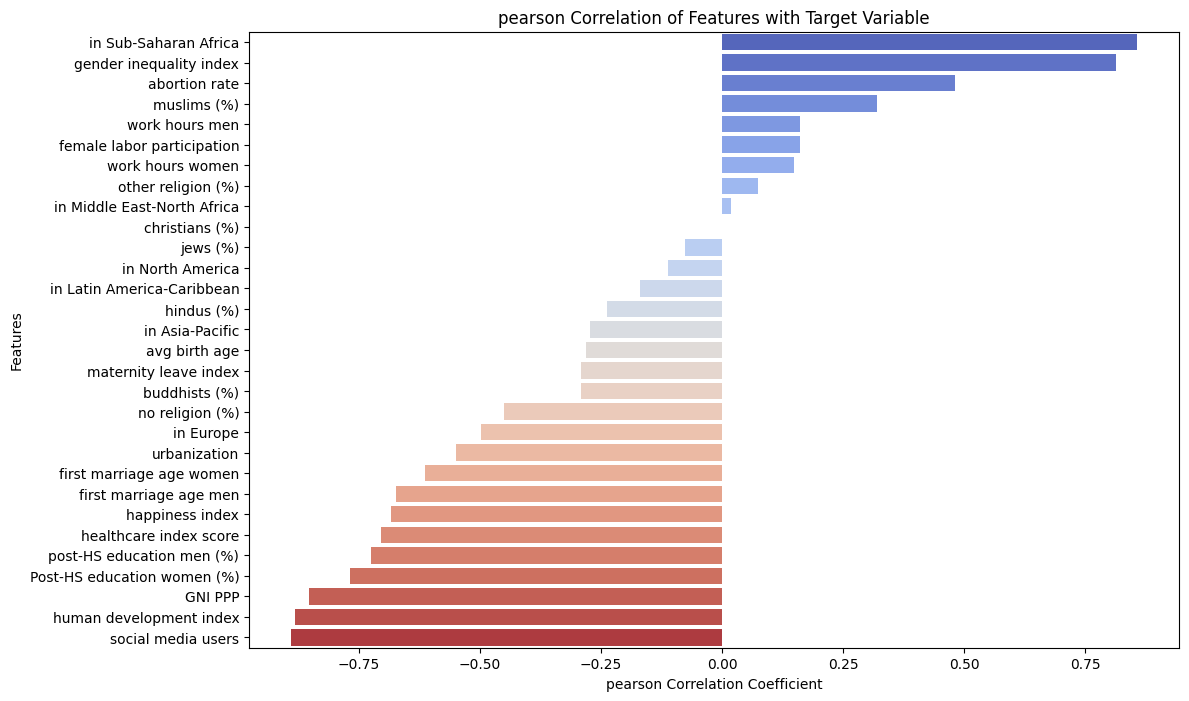


pearson Correlation with Target:
in Sub-Saharan Africa          0.856788
gender inequality index        0.814912
abortion rate                  0.481189
muslims (%)                    0.321094
work hours men                 0.160676
female labor participation     0.160287
work hours women               0.149026
other religion (%)             0.074008
in Middle East-North Africa    0.019418
christians (%)                 0.000515
jews (%)                      -0.075971
in North America              -0.111411
in Latin America-Caribbean    -0.170361
hindus (%)                    -0.237167
in Asia-Pacific               -0.273279
avg birth age                 -0.281065
maternity leave index         -0.290619
buddhists (%)                 -0.291736
no religion (%)               -0.449896
in Europe                     -0.497317
urbanization                  -0.548769
first marriage age women      -0.612978
first marriage age men        -0.674392
happiness index               -0.684732
health

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


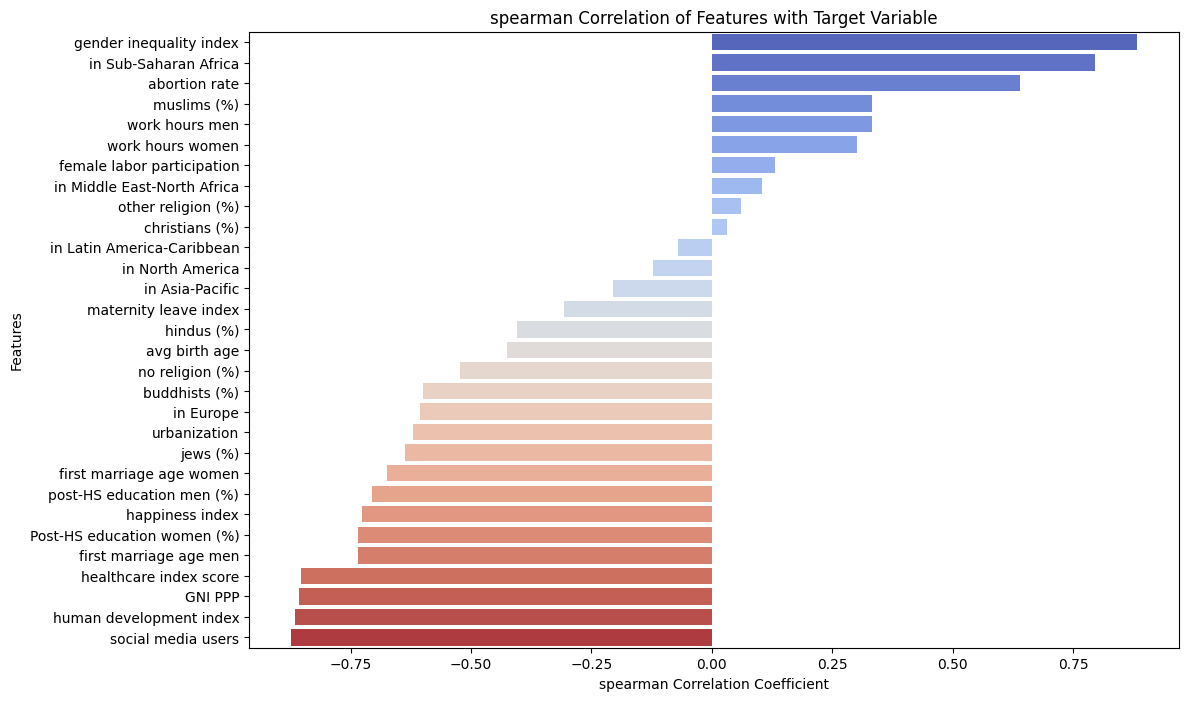


spearman Correlation with Target:
gender inequality index        0.882303
in Sub-Saharan Africa          0.794807
abortion rate                  0.640375
muslims (%)                    0.332363
work hours men                 0.332265
work hours women               0.300760
female labor participation     0.131677
in Middle East-North Africa    0.104932
other religion (%)             0.060858
christians (%)                 0.031758
in Latin America-Caribbean    -0.071322
in North America              -0.122445
in Asia-Pacific               -0.204309
maternity leave index         -0.307832
hindus (%)                    -0.404624
avg birth age                 -0.425574
no religion (%)               -0.522893
buddhists (%)                 -0.600332
in Europe                     -0.605139
urbanization                  -0.619974
jews (%)                      -0.636714
first marriage age women      -0.675069
post-HS education men (%)     -0.706588
happiness index               -0.727373
Post-

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


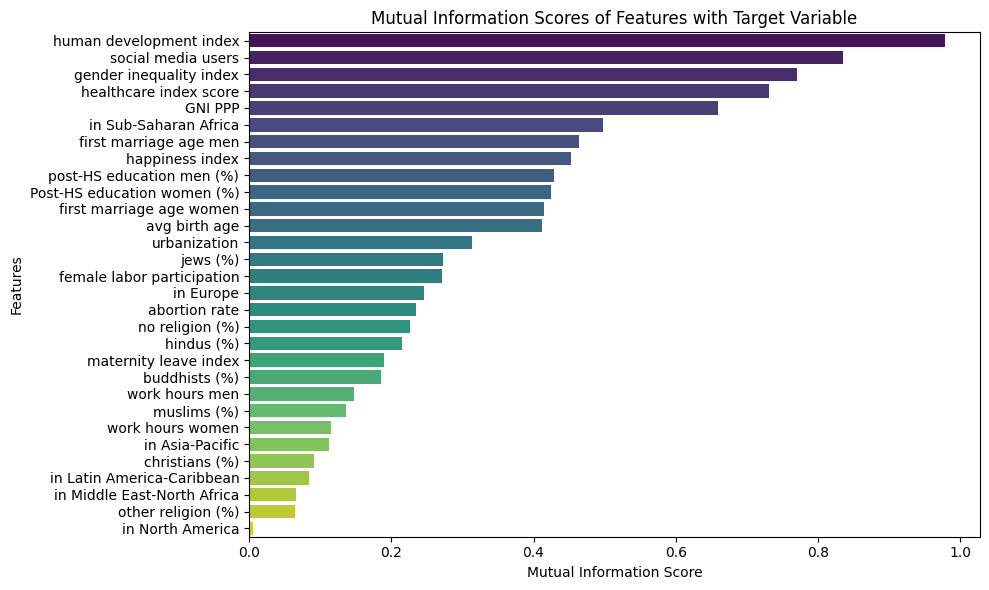


lasso regressor:
Best params: {'lasso__alpha': 0.01}
CV MSE: 0.2841 (±0.5242)
Train accuracy:
MSE: 0.1558

coefficients:
human development index: -0.6816
in Sub-Saharan Africa: 0.5756
social media users: -0.3692
gender inequality index: 0.1996
avg birth age: 0.1535
post-HS education men (%): 0.1477
jews (%): 0.1280
happiness index: 0.1279
first marriage age men: -0.1234
work hours men: -0.1114
muslims (%): 0.0953
urbanization: 0.0787
healthcare index score: 0.0646
buddhists (%): -0.0518
female labor participation: 0.0509
hindus (%): -0.0381
abortion rate: 0.0294
other religion (%): -0.0229
in Middle East-North Africa: 0.0134
no religion (%): 0.0110
Post-HS education women (%): -0.0040
christians (%): -0.0000
in Europe: -0.0000
in Asia-Pacific: -0.0000
GNI PPP: -0.0000
in North America: -0.0000
in Latin America-Caribbean: -0.0000
first marriage age women: -0.0000
maternity leave index: -0.0000
work hours women: -0.0000

ridge regressor:
Best params: {'ridge__alpha': 10}
CV MSE: 0.2716 

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


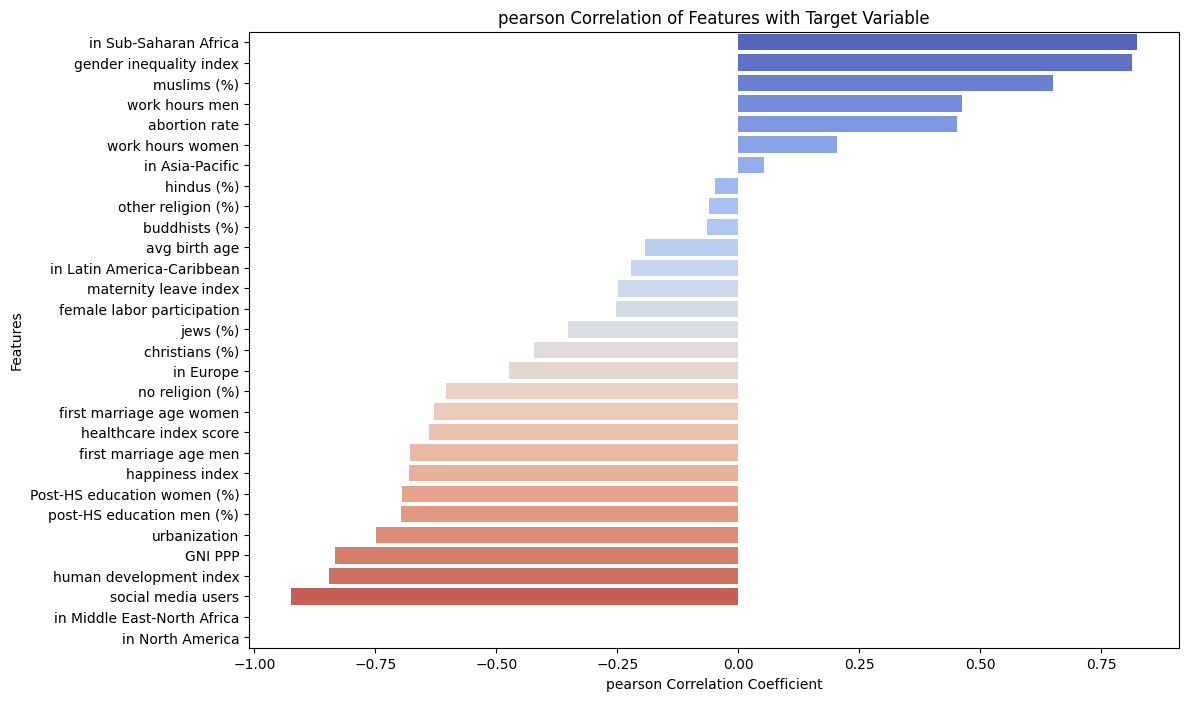


pearson Correlation with Target:
in Sub-Saharan Africa          0.823179
gender inequality index        0.812352
muslims (%)                    0.649306
work hours men                 0.462830
abortion rate                  0.452339
work hours women               0.203023
in Asia-Pacific                0.052335
hindus (%)                    -0.047746
other religion (%)            -0.060001
buddhists (%)                 -0.064822
avg birth age                 -0.192350
in Latin America-Caribbean    -0.222523
maternity leave index         -0.249138
female labor participation    -0.252502
jews (%)                      -0.352532
christians (%)                -0.422458
in Europe                     -0.474789
no religion (%)               -0.603451
first marriage age women      -0.629571
healthcare index score        -0.639214
first marriage age men        -0.679124
happiness index               -0.679423
Post-HS education women (%)   -0.695747
post-HS education men (%)     -0.695863
urbani

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


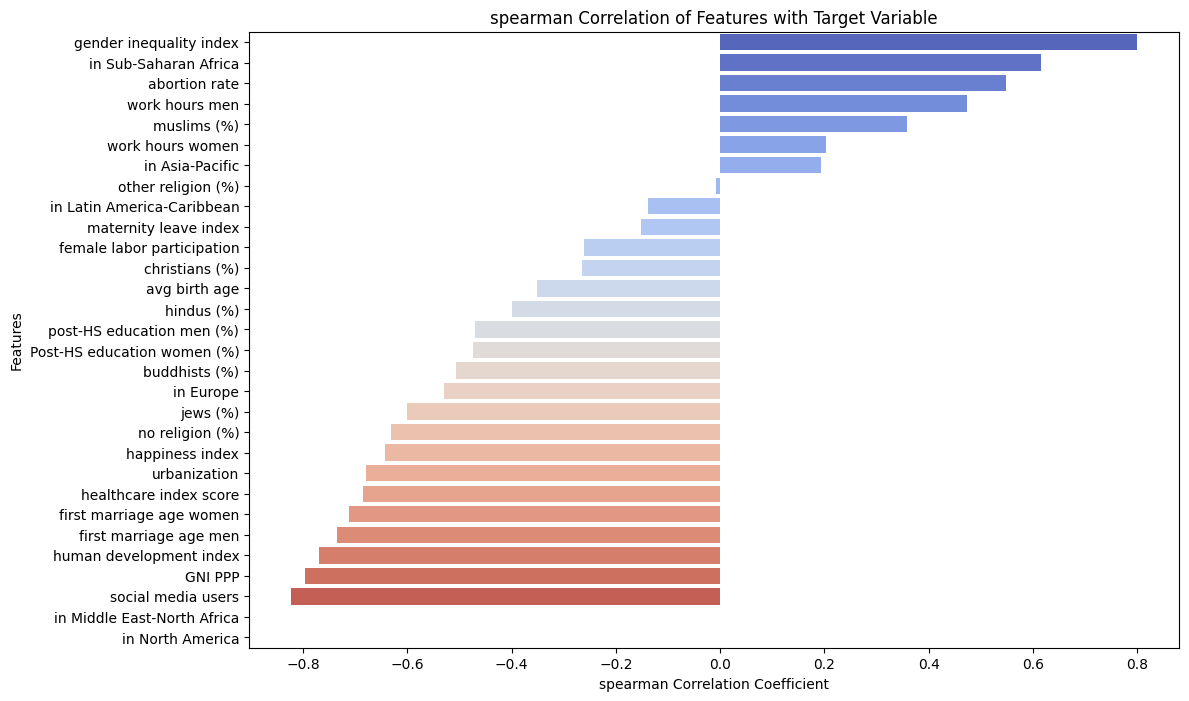


spearman Correlation with Target:
gender inequality index        0.799175
in Sub-Saharan Africa          0.616010
abortion rate                  0.548190
work hours men                 0.474271
muslims (%)                    0.359444
work hours women               0.202505
in Asia-Pacific                0.192741
other religion (%)            -0.007024
in Latin America-Caribbean    -0.137316
maternity leave index         -0.150811
female labor participation    -0.261414
christians (%)                -0.264468
avg birth age                 -0.351199
hindus (%)                    -0.400061
post-HS education men (%)     -0.470606
Post-HS education women (%)   -0.473049
buddhists (%)                 -0.506720
in Europe                     -0.529817
jews (%)                      -0.600245
no religion (%)               -0.631547
happiness index               -0.643457
urbanization                  -0.678272
healthcare index score        -0.685296
first marriage age women      -0.712082
first

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


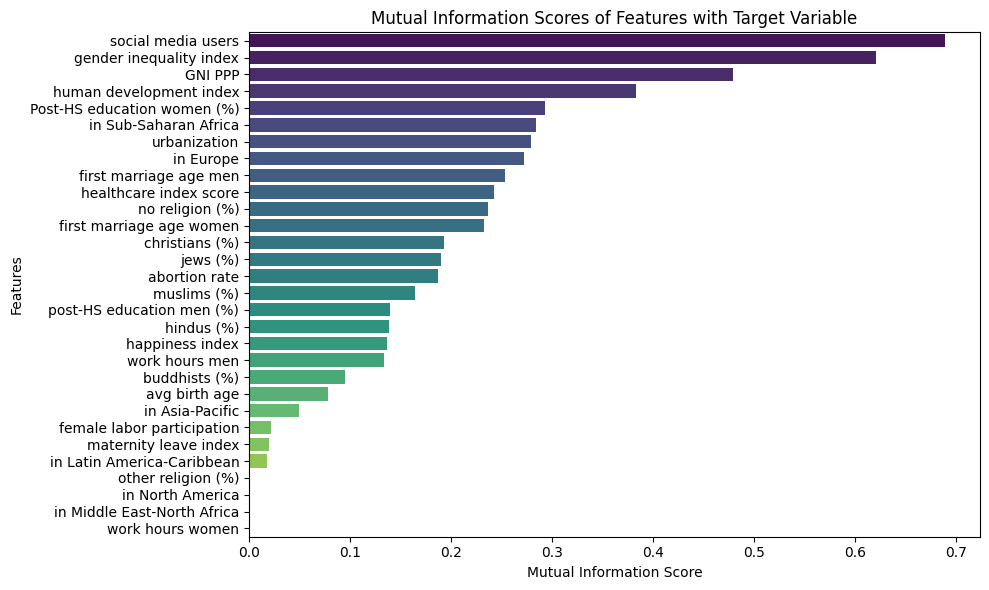


lasso regressor final results:
MSE: 0.1543

ridge regressor final results:
MSE: 0.1897

random forest regressor final results:
MSE: 0.1655

xgboost regressor final results:
MSE: 0.1893
multiple year(1991,2007,2023) data analysis
unscaled features


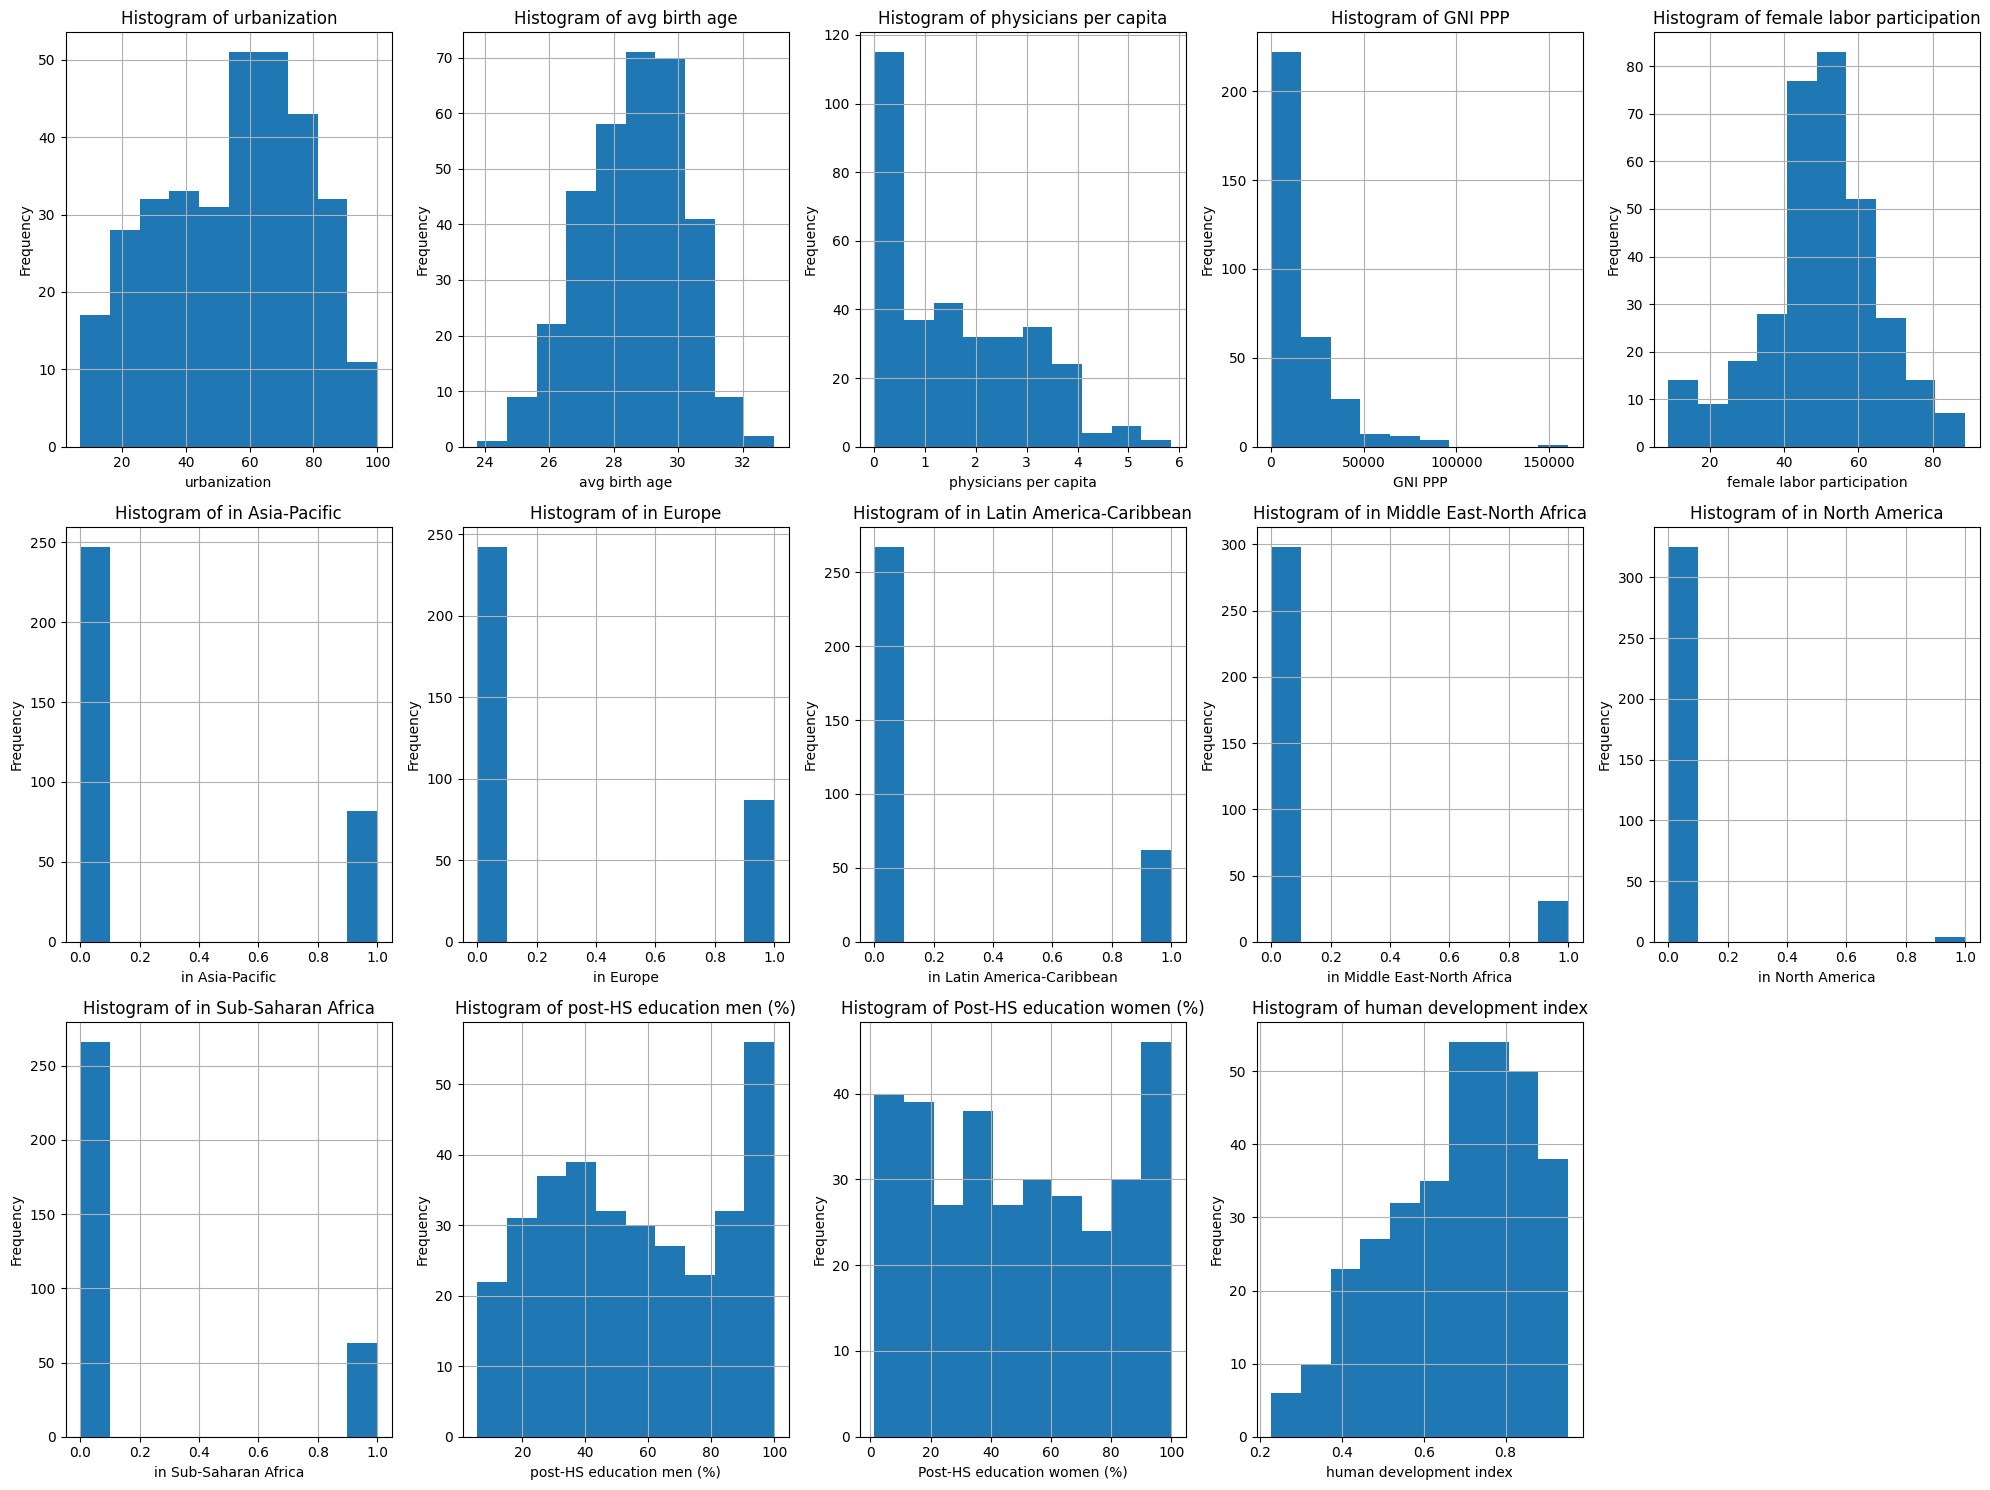

scaled features


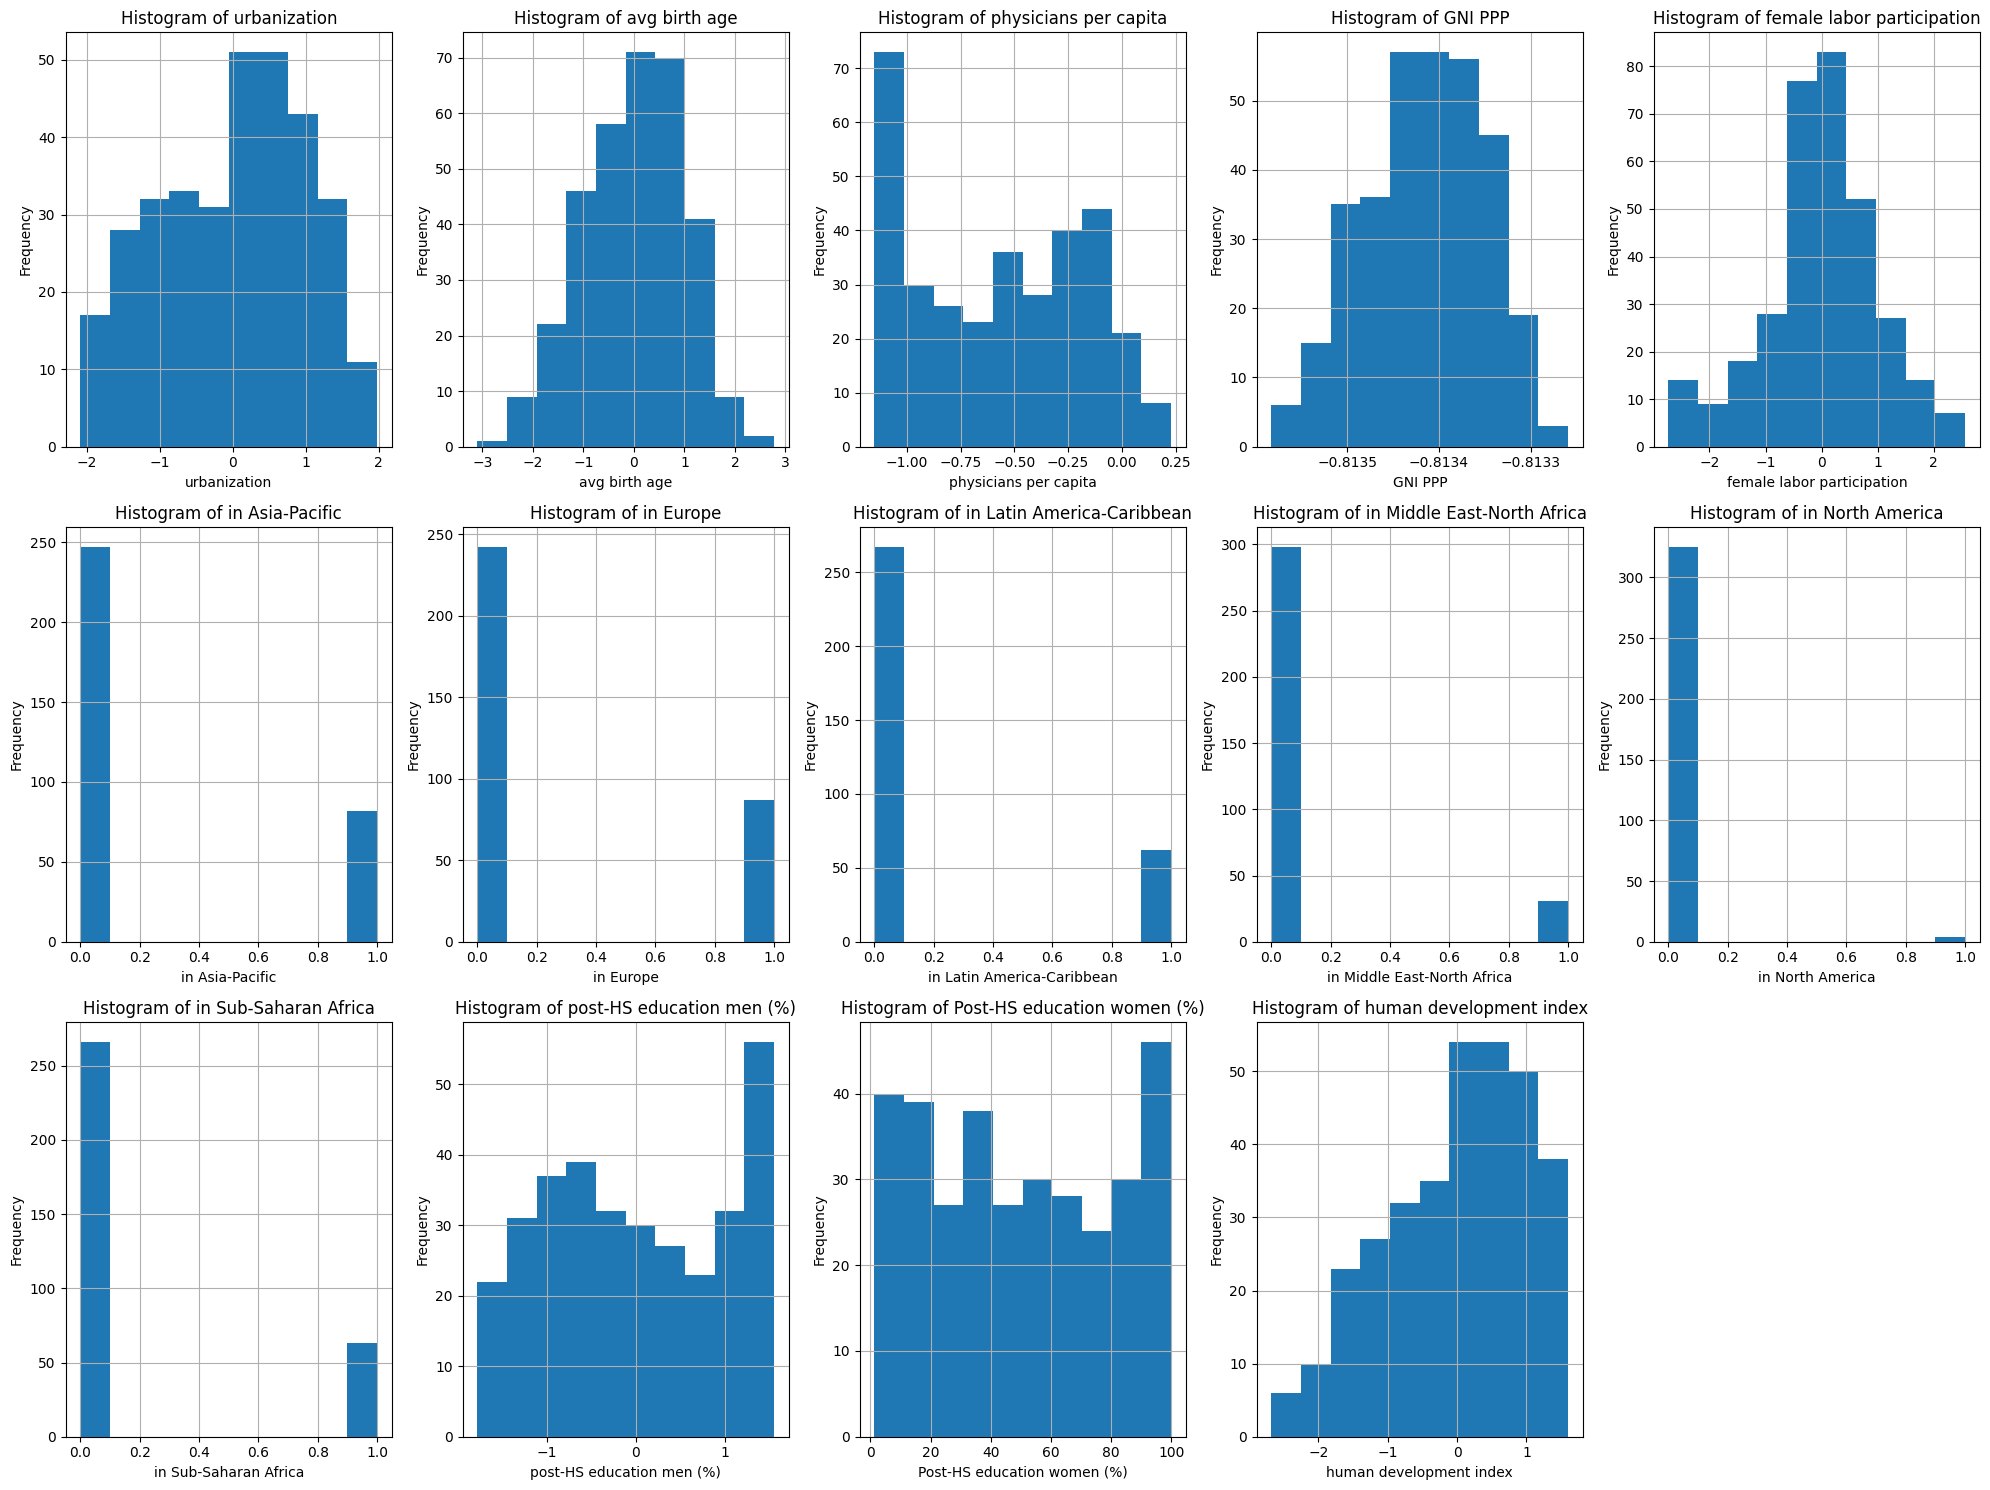


feature pairs correlations:


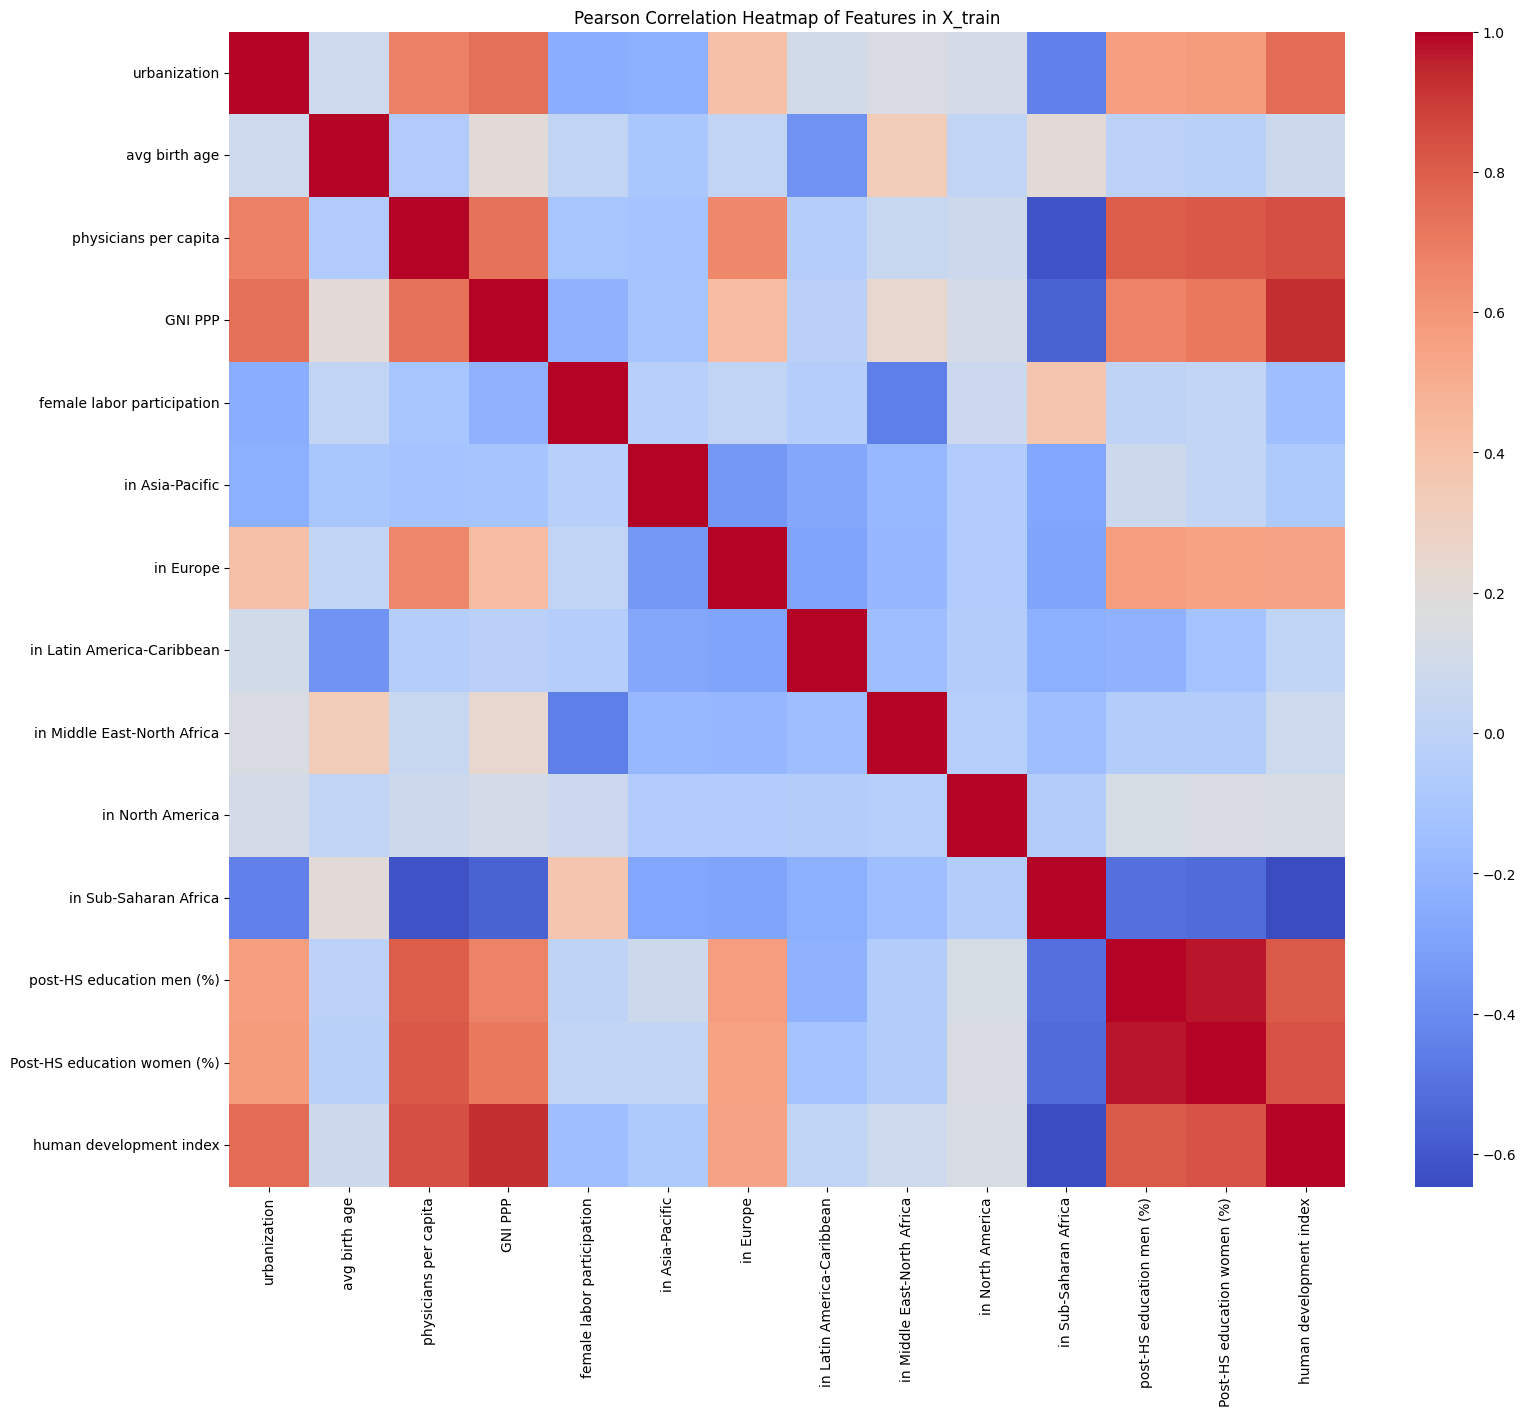


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  post-HS education men (%) and Post-HS education women (%): 0.9734
  GNI PPP and human development index: 0.9303
  physicians per capita and human development index: 0.8415
  Post-HS education women (%) and human development index: 0.8389
  physicians per capita and Post-HS education women (%): 0.8178


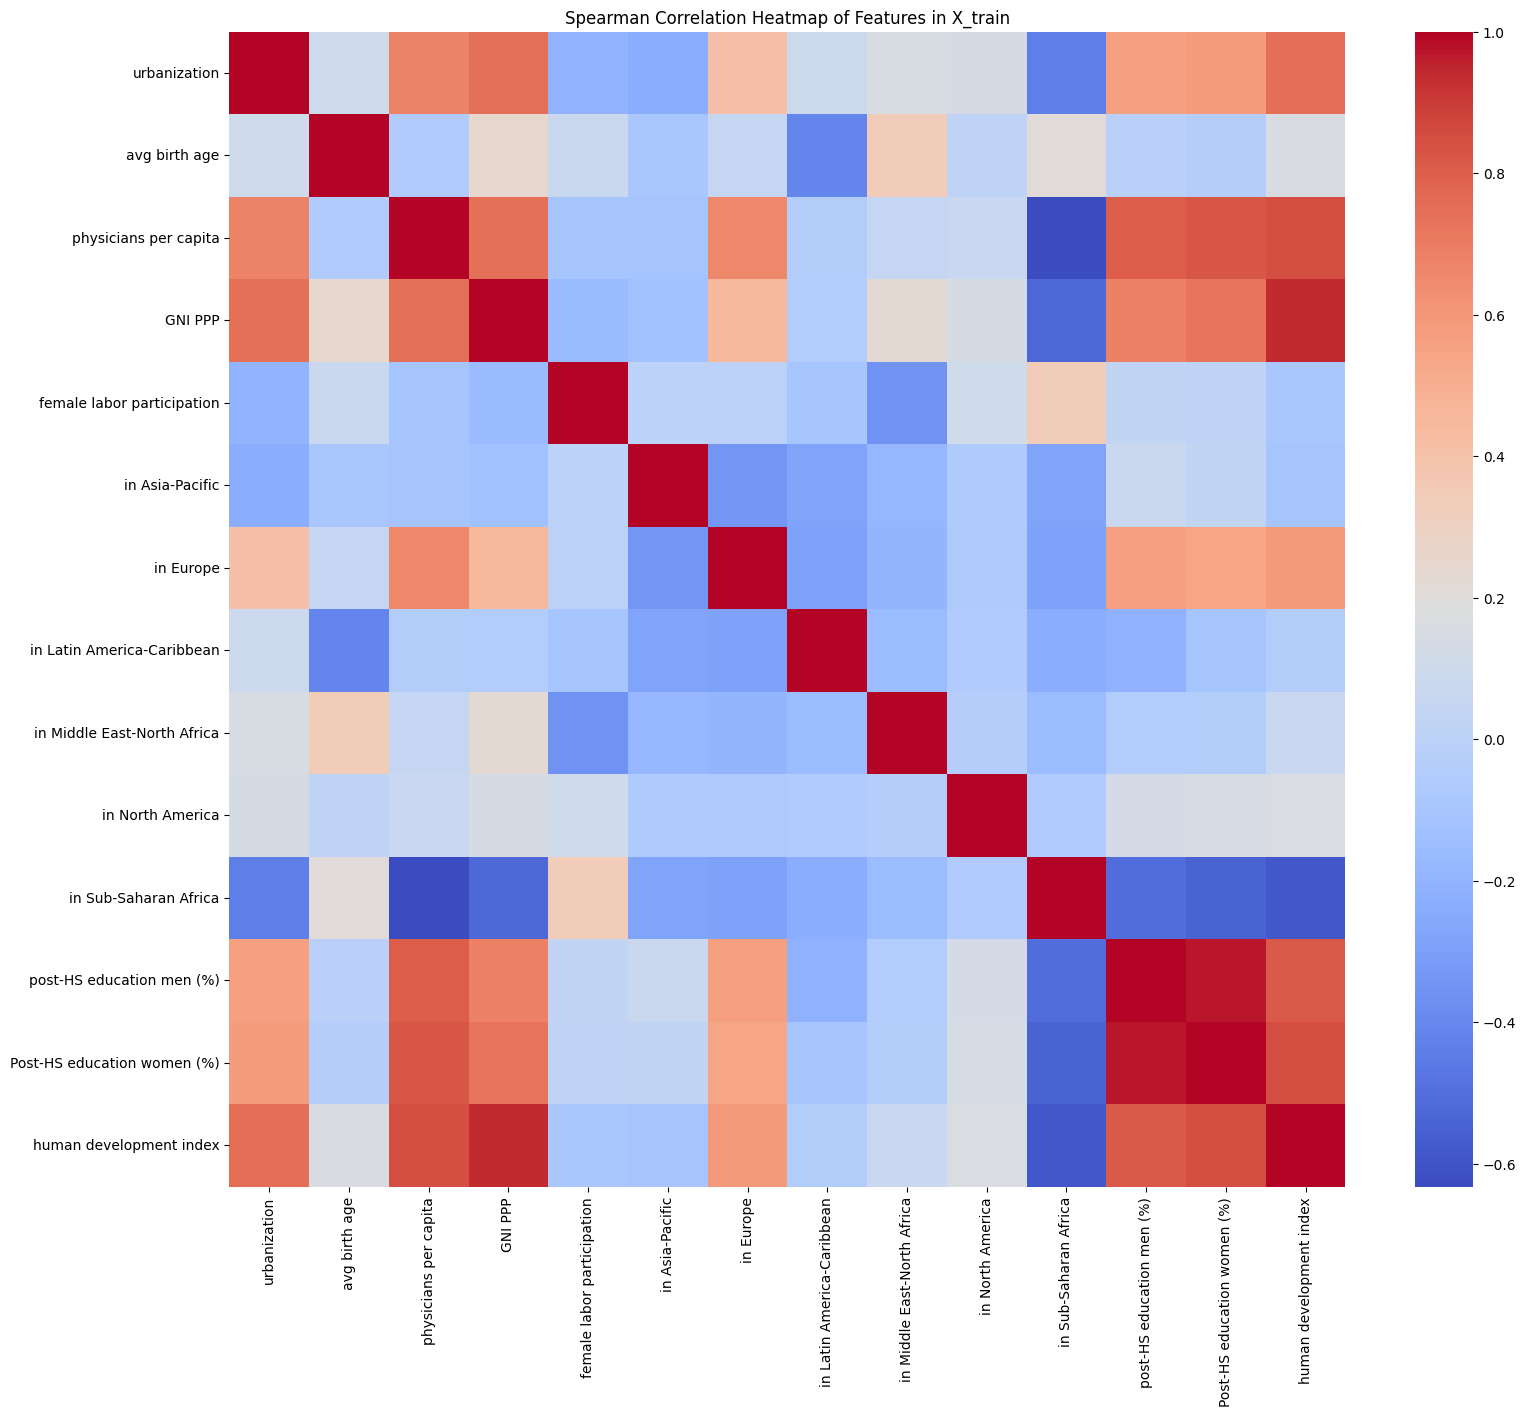


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  post-HS education men (%) and Post-HS education women (%): 0.9734
  GNI PPP and human development index: 0.9392
  physicians per capita and human development index: 0.8495
  Post-HS education women (%) and human development index: 0.8476
  physicians per capita and Post-HS education women (%): 0.8225


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


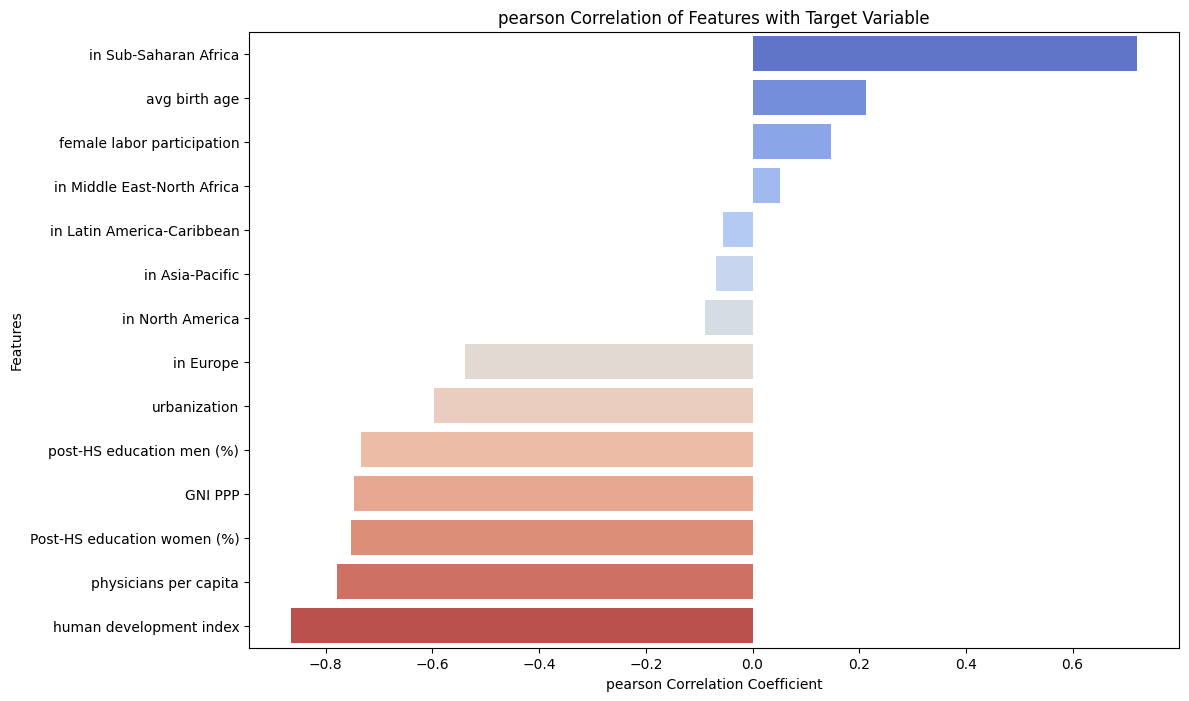


pearson Correlation with Target:
in Sub-Saharan Africa          0.720218
avg birth age                  0.213628
female labor participation     0.147813
in Middle East-North Africa    0.051533
in Latin America-Caribbean    -0.056268
in Asia-Pacific               -0.067542
in North America              -0.089799
in Europe                     -0.538233
urbanization                  -0.597051
post-HS education men (%)     -0.733938
GNI PPP                       -0.747775
Post-HS education women (%)   -0.753242
physicians per capita         -0.777964
human development index       -0.864559
Name: target, dtype: float64


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


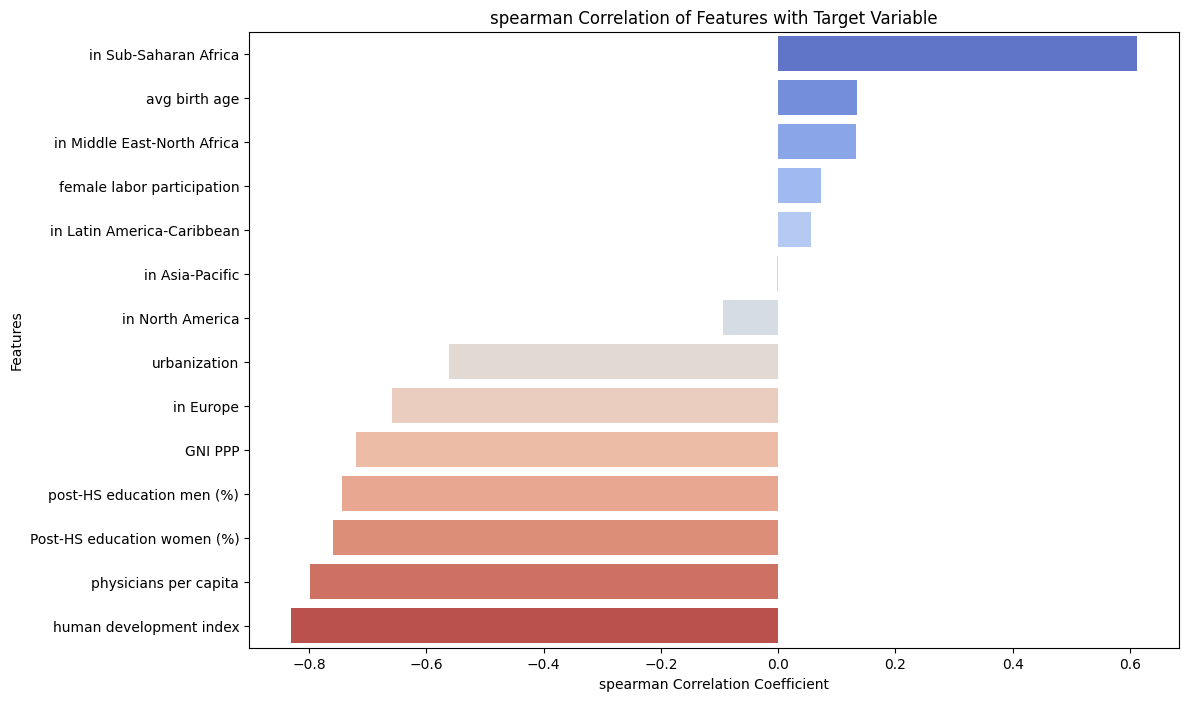


spearman Correlation with Target:
in Sub-Saharan Africa          0.611410
avg birth age                  0.134425
in Middle East-North Africa    0.132664
female labor participation     0.072443
in Latin America-Caribbean     0.056385
in Asia-Pacific               -0.002072
in North America              -0.094180
urbanization                  -0.561726
in Europe                     -0.657918
GNI PPP                       -0.720422
post-HS education men (%)     -0.743898
Post-HS education women (%)   -0.759614
physicians per capita         -0.797923
human development index       -0.830292
Name: target, dtype: float64
Mutual Information Scores of Features with Target Variable:
human development index        0.659541
Post-HS education women (%)    0.541398
physicians per capita          0.507759
GNI PPP                        0.505990
post-HS education men (%)      0.430399
in Europe                      0.297330
in Sub-Saharan Africa          0.262189
urbanization                   0.247

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


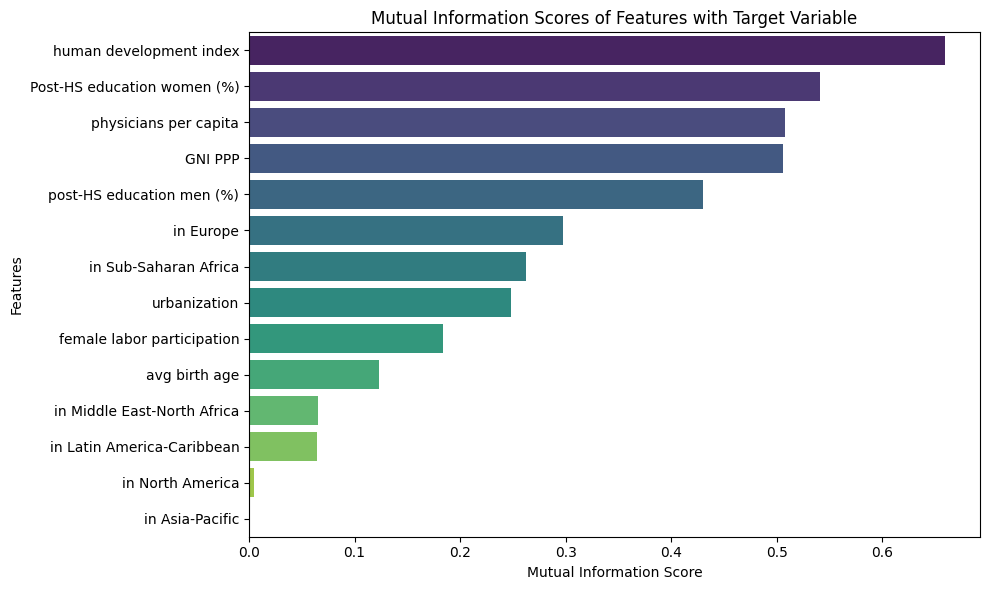


lasso regressor:
Best params: {'lasso__alpha': 0.003}
CV MSE: 0.3818 (±0.6722)
Train accuracy:
MSE: 0.3568

coefficients:
human development index: -1.3318
in Europe: -0.5168
in Sub-Saharan Africa: 0.4914
in Asia-Pacific: -0.3966
avg birth age: 0.3907
urbanization: 0.0791
female labor participation: -0.0294
Post-HS education women (%): 0.0035
physicians per capita: 0.0000
GNI PPP: 0.0000
in North America: 0.0000
in Middle East-North Africa: -0.0000
in Latin America-Caribbean: 0.0000
post-HS education men (%): -0.0000

ridge regressor:
Best params: {'ridge__alpha': 3}
CV MSE: 0.3884 (±0.6798)
Train accuracy:
MSE: 0.3575

coefficients:
human development index: -1.2843
in Sub-Saharan Africa: 0.5723
in Europe: -0.4393
avg birth age: 0.3876
in Asia-Pacific: -0.3205
in Latin America-Caribbean: 0.0795
urbanization: 0.0680
in Middle East-North Africa: 0.0608
in North America: 0.0473
female labor participation: -0.0303
physicians per capita: -0.0247
Post-HS education women (%): 0.0027
post-HS e

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


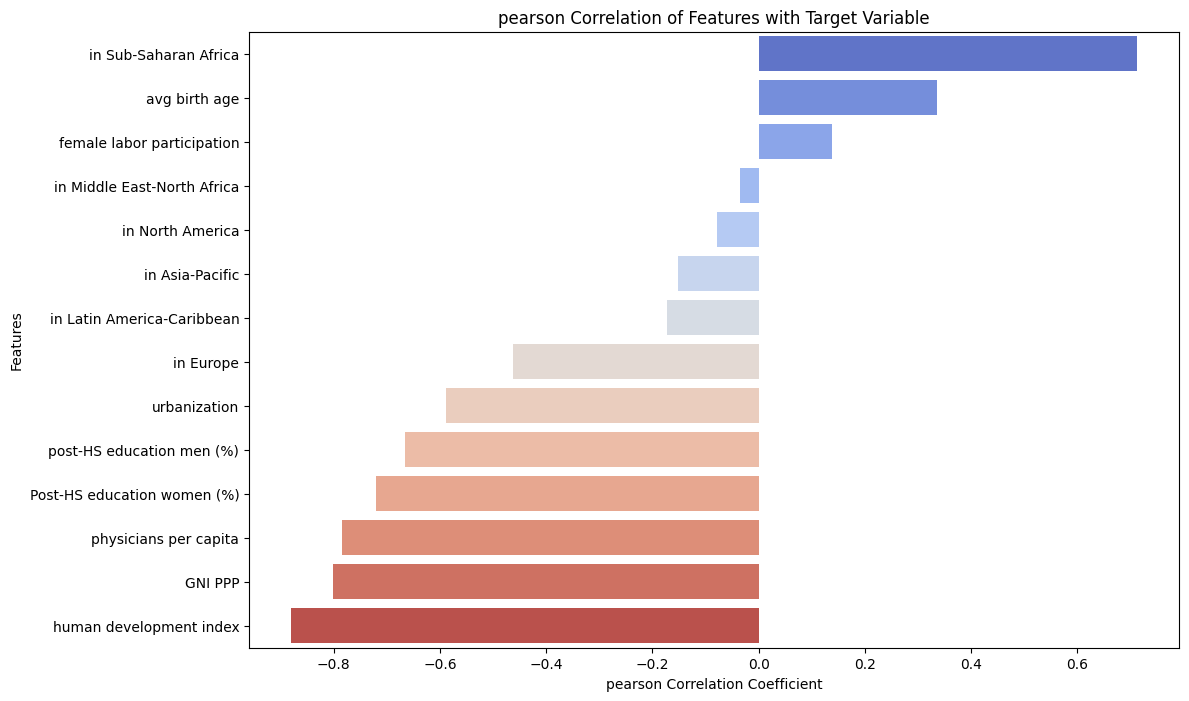


pearson Correlation with Target:
in Sub-Saharan Africa          0.711521
avg birth age                  0.336310
female labor participation     0.138159
in Middle East-North Africa   -0.035416
in North America              -0.079173
in Asia-Pacific               -0.152778
in Latin America-Caribbean    -0.172683
in Europe                     -0.462416
urbanization                  -0.589108
post-HS education men (%)     -0.665413
Post-HS education women (%)   -0.720102
physicians per capita         -0.784216
GNI PPP                       -0.800648
human development index       -0.879626
Name: target, dtype: float64


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


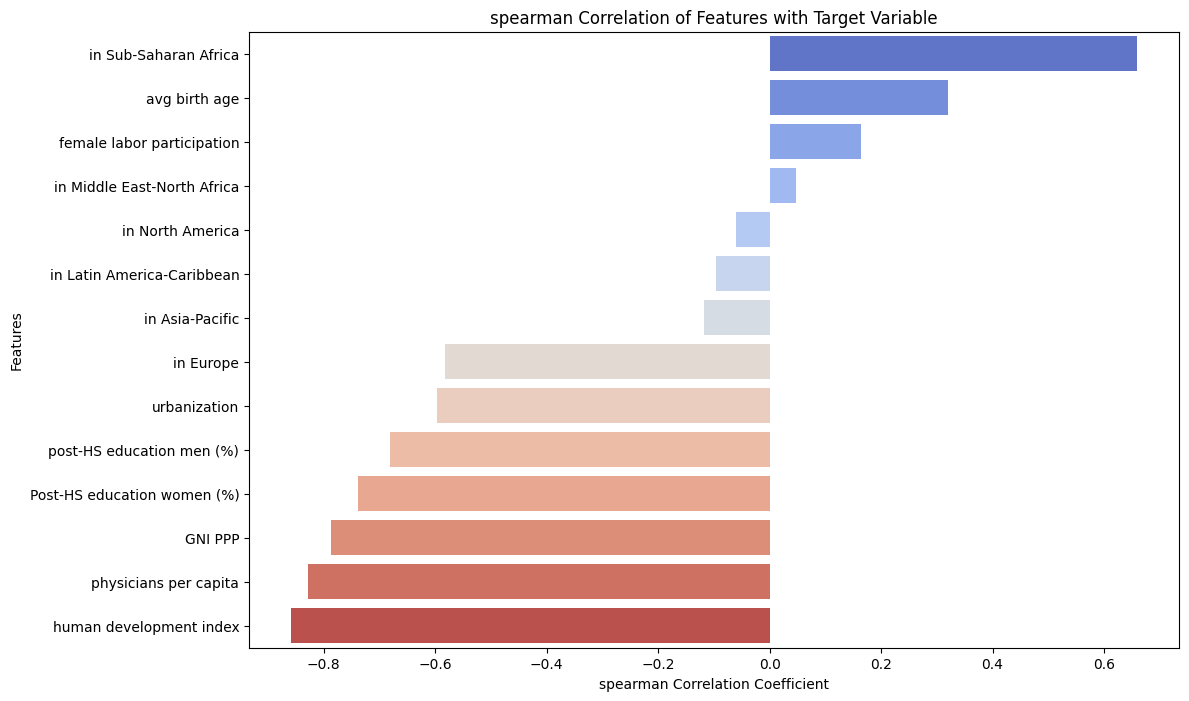


spearman Correlation with Target:
in Sub-Saharan Africa          0.658778
avg birth age                  0.319996
female labor participation     0.164699
in Middle East-North Africa    0.046904
in North America              -0.059922
in Latin America-Caribbean    -0.096692
in Asia-Pacific               -0.118500
in Europe                     -0.582886
urbanization                  -0.597140
post-HS education men (%)     -0.681696
Post-HS education women (%)   -0.738180
GNI PPP                       -0.787230
physicians per capita         -0.827605
human development index       -0.858392
Name: target, dtype: float64
Mutual Information Scores of Features with Target Variable:
human development index        0.763112
GNI PPP                        0.495891
Post-HS education women (%)    0.478257
physicians per capita          0.416423
post-HS education men (%)      0.367483
urbanization                   0.302014
in Sub-Saharan Africa          0.274900
in Europe                      0.224

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


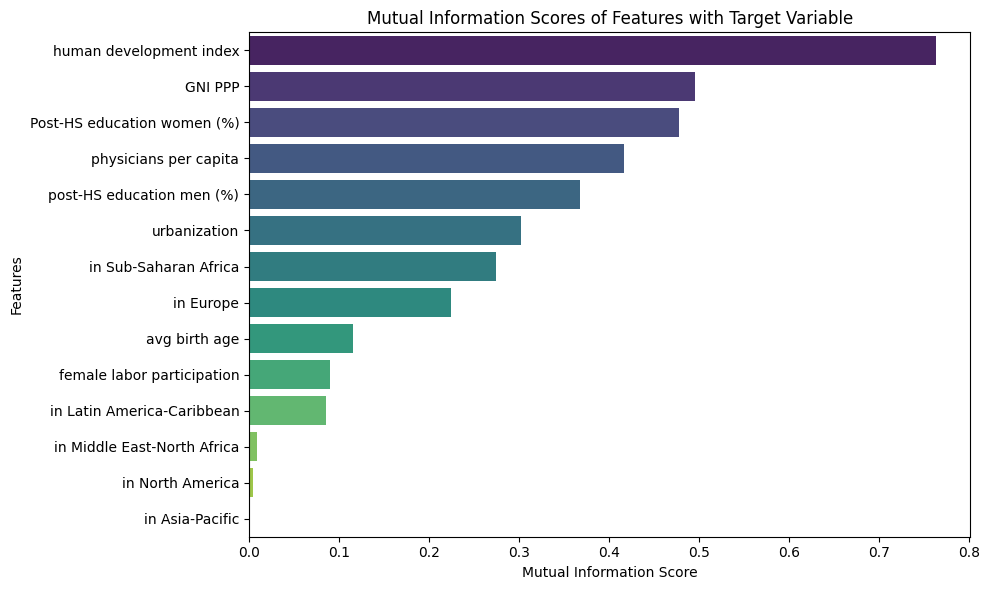


lasso regressor final results:
MSE: 0.4417

ridge regressor final results:
MSE: 0.4440

random forest regressor final results:
MSE: 0.3991

xgboost regressor final results:
MSE: 0.3326


In [44]:
data=init_process()
print("2023 data analysis")
X_train_2023, X_test_2023, y_train_2023, y_test_2023, lasso_gs_2023, ridge_gs_2023, rf_gs_2023, xgb_gs_2023 = exec_experiments(data,False)
print("multiple year(1991,2007,2023) data analysis")
X_train_multi, X_test_multi, y_train_multi, y_test_multi, lasso_gs_multi, ridge_gs_multi, rf_gs_multi, xgb_gs_multi = exec_experiments(data,True)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming grid_search_rf, X_train, y_train, X_test, and y_test are already defined

# Get the best trained Random Forest model
best_rf_model = rf_gs.best_estimator_

# --- Evaluate on Training Set ---
y_train_pred_rf = best_rf_model.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print(f"Training Set Performance:")
print(f"  Mean Squared Error: {mse_train_rf:.4f}")
print(f"  R-squared: {r2_train_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Evaluate on Test Set ---
y_test_pred_rf = best_rf_model.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"Test Set Performance:")
print(f"  Mean Squared Error: {mse_test_rf:.4f}")
print(f"  R-squared: {r2_test_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Validation Set Performance (from Grid Search) ---
# The best_score_ from GridSearchCV is the mean cross-validation score (negative MSE)
validation_neg_mse = rf_gs.best_score_
validation_mse = -validation_neg_mse # Convert negative MSE to positive MSE

print(f"Validation Set Performance (from Grid Search):")
print(f"  Mean Cross-Validation MSE: {validation_mse:.4f}")
# Note: R-squared is not directly available from best_score_ if MSE was the scoring metric
# You could calculate R-squared on the validation folds separately if needed.

Training Set Performance:
  Mean Squared Error: 0.0740
  R-squared: 0.9602


Test Set Performance:
  Mean Squared Error: 0.1473
  R-squared: 0.8882


Validation Set Performance (from Grid Search):
  Mean Cross-Validation MSE: 0.3397


Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

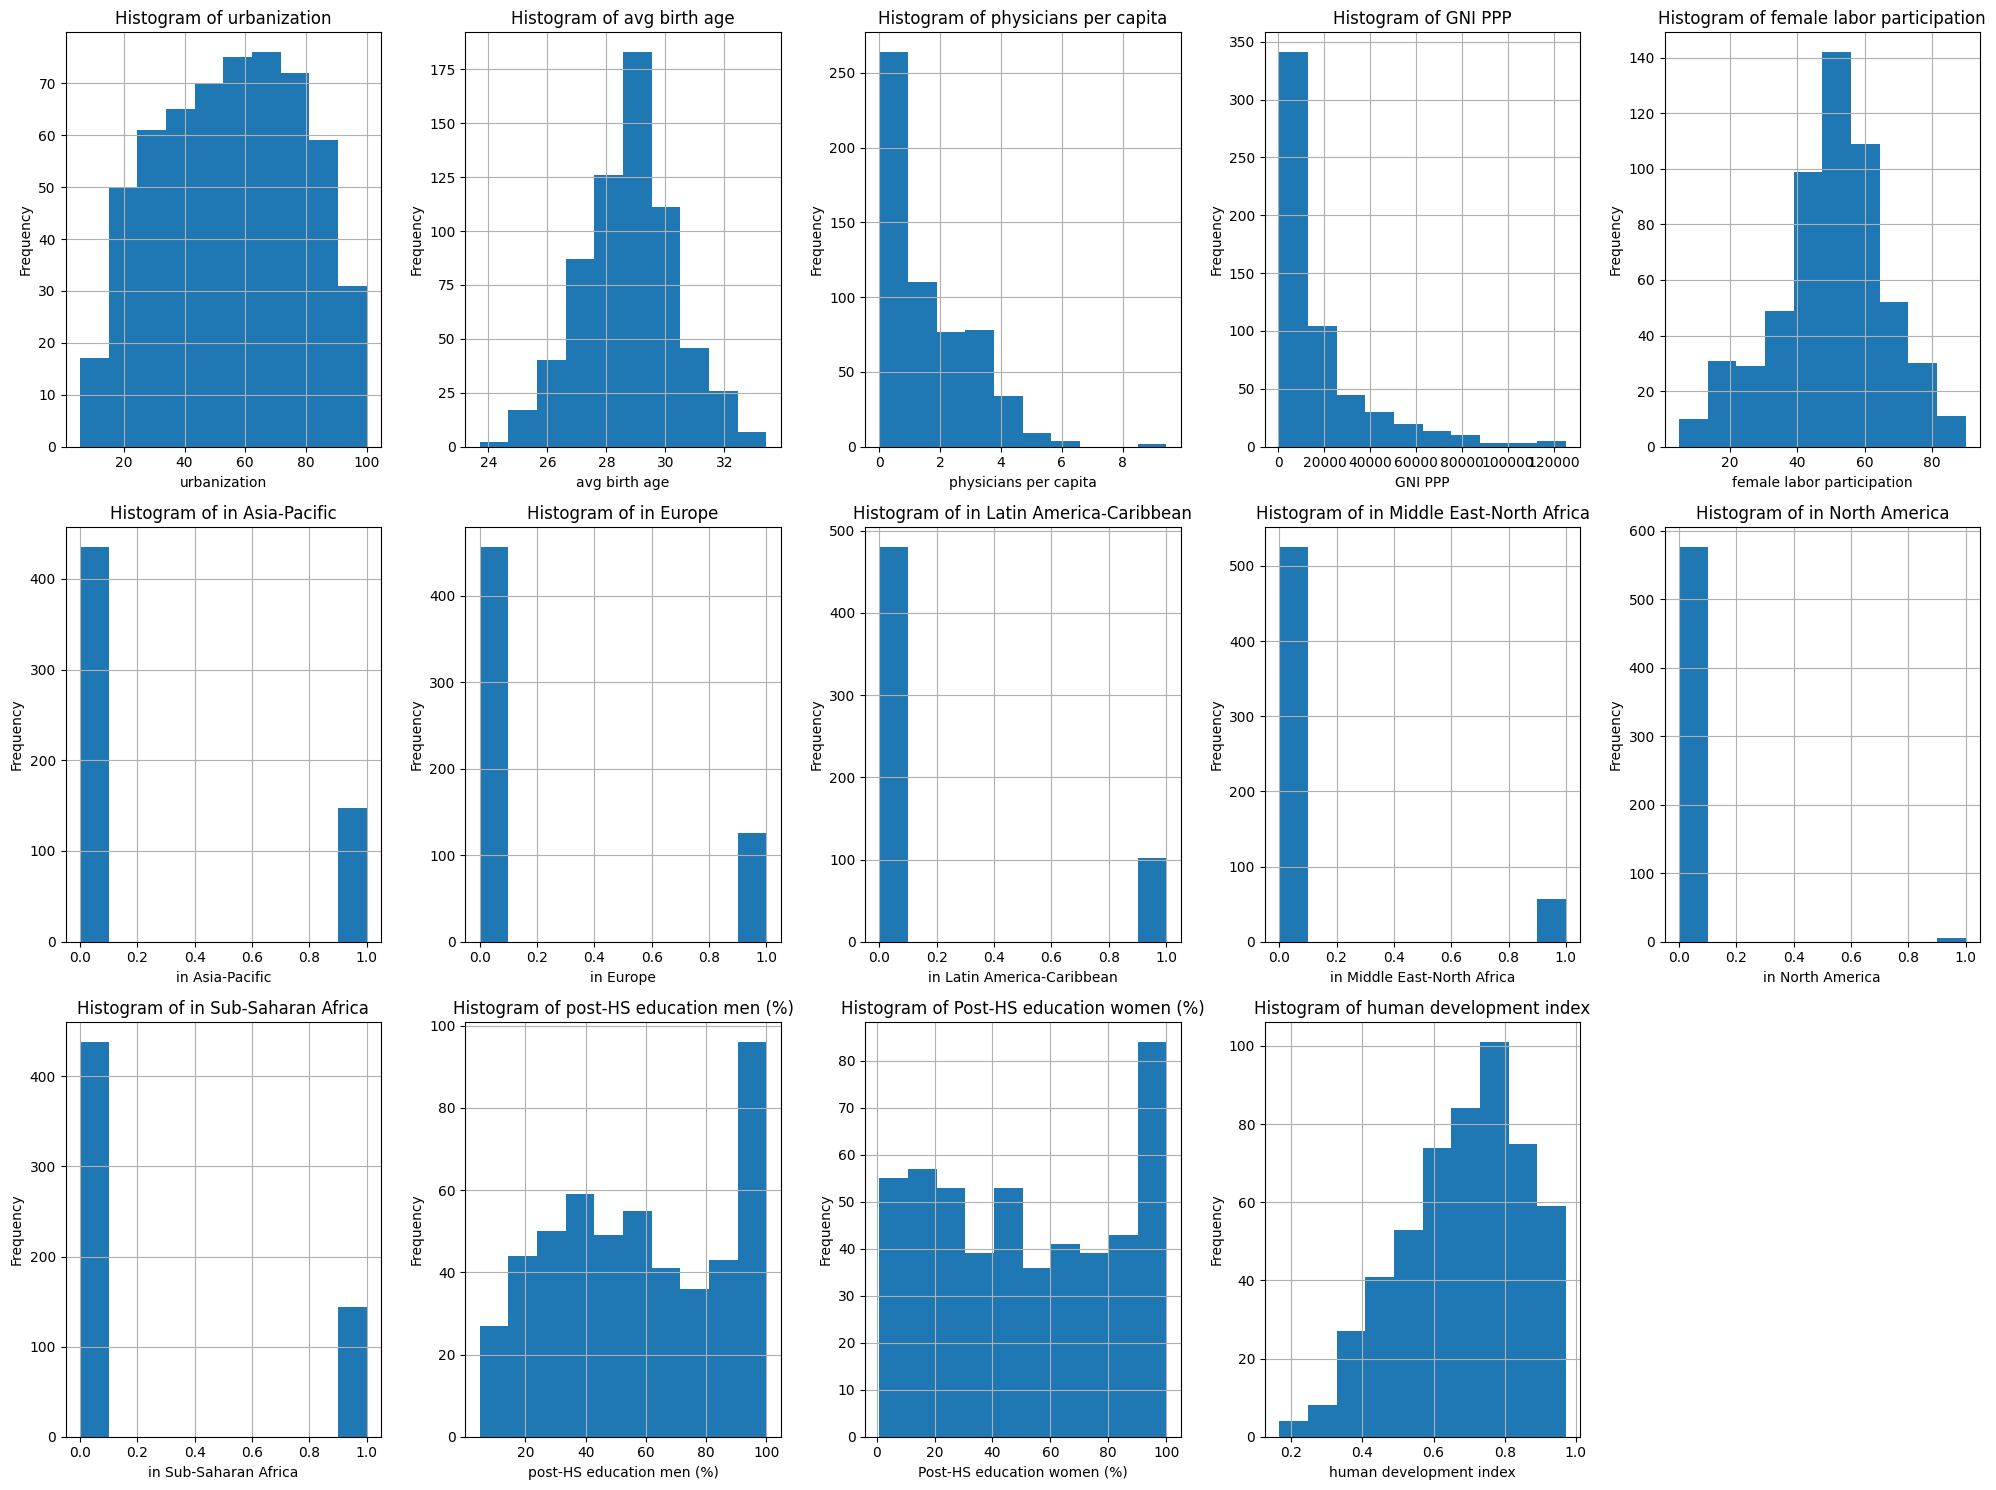

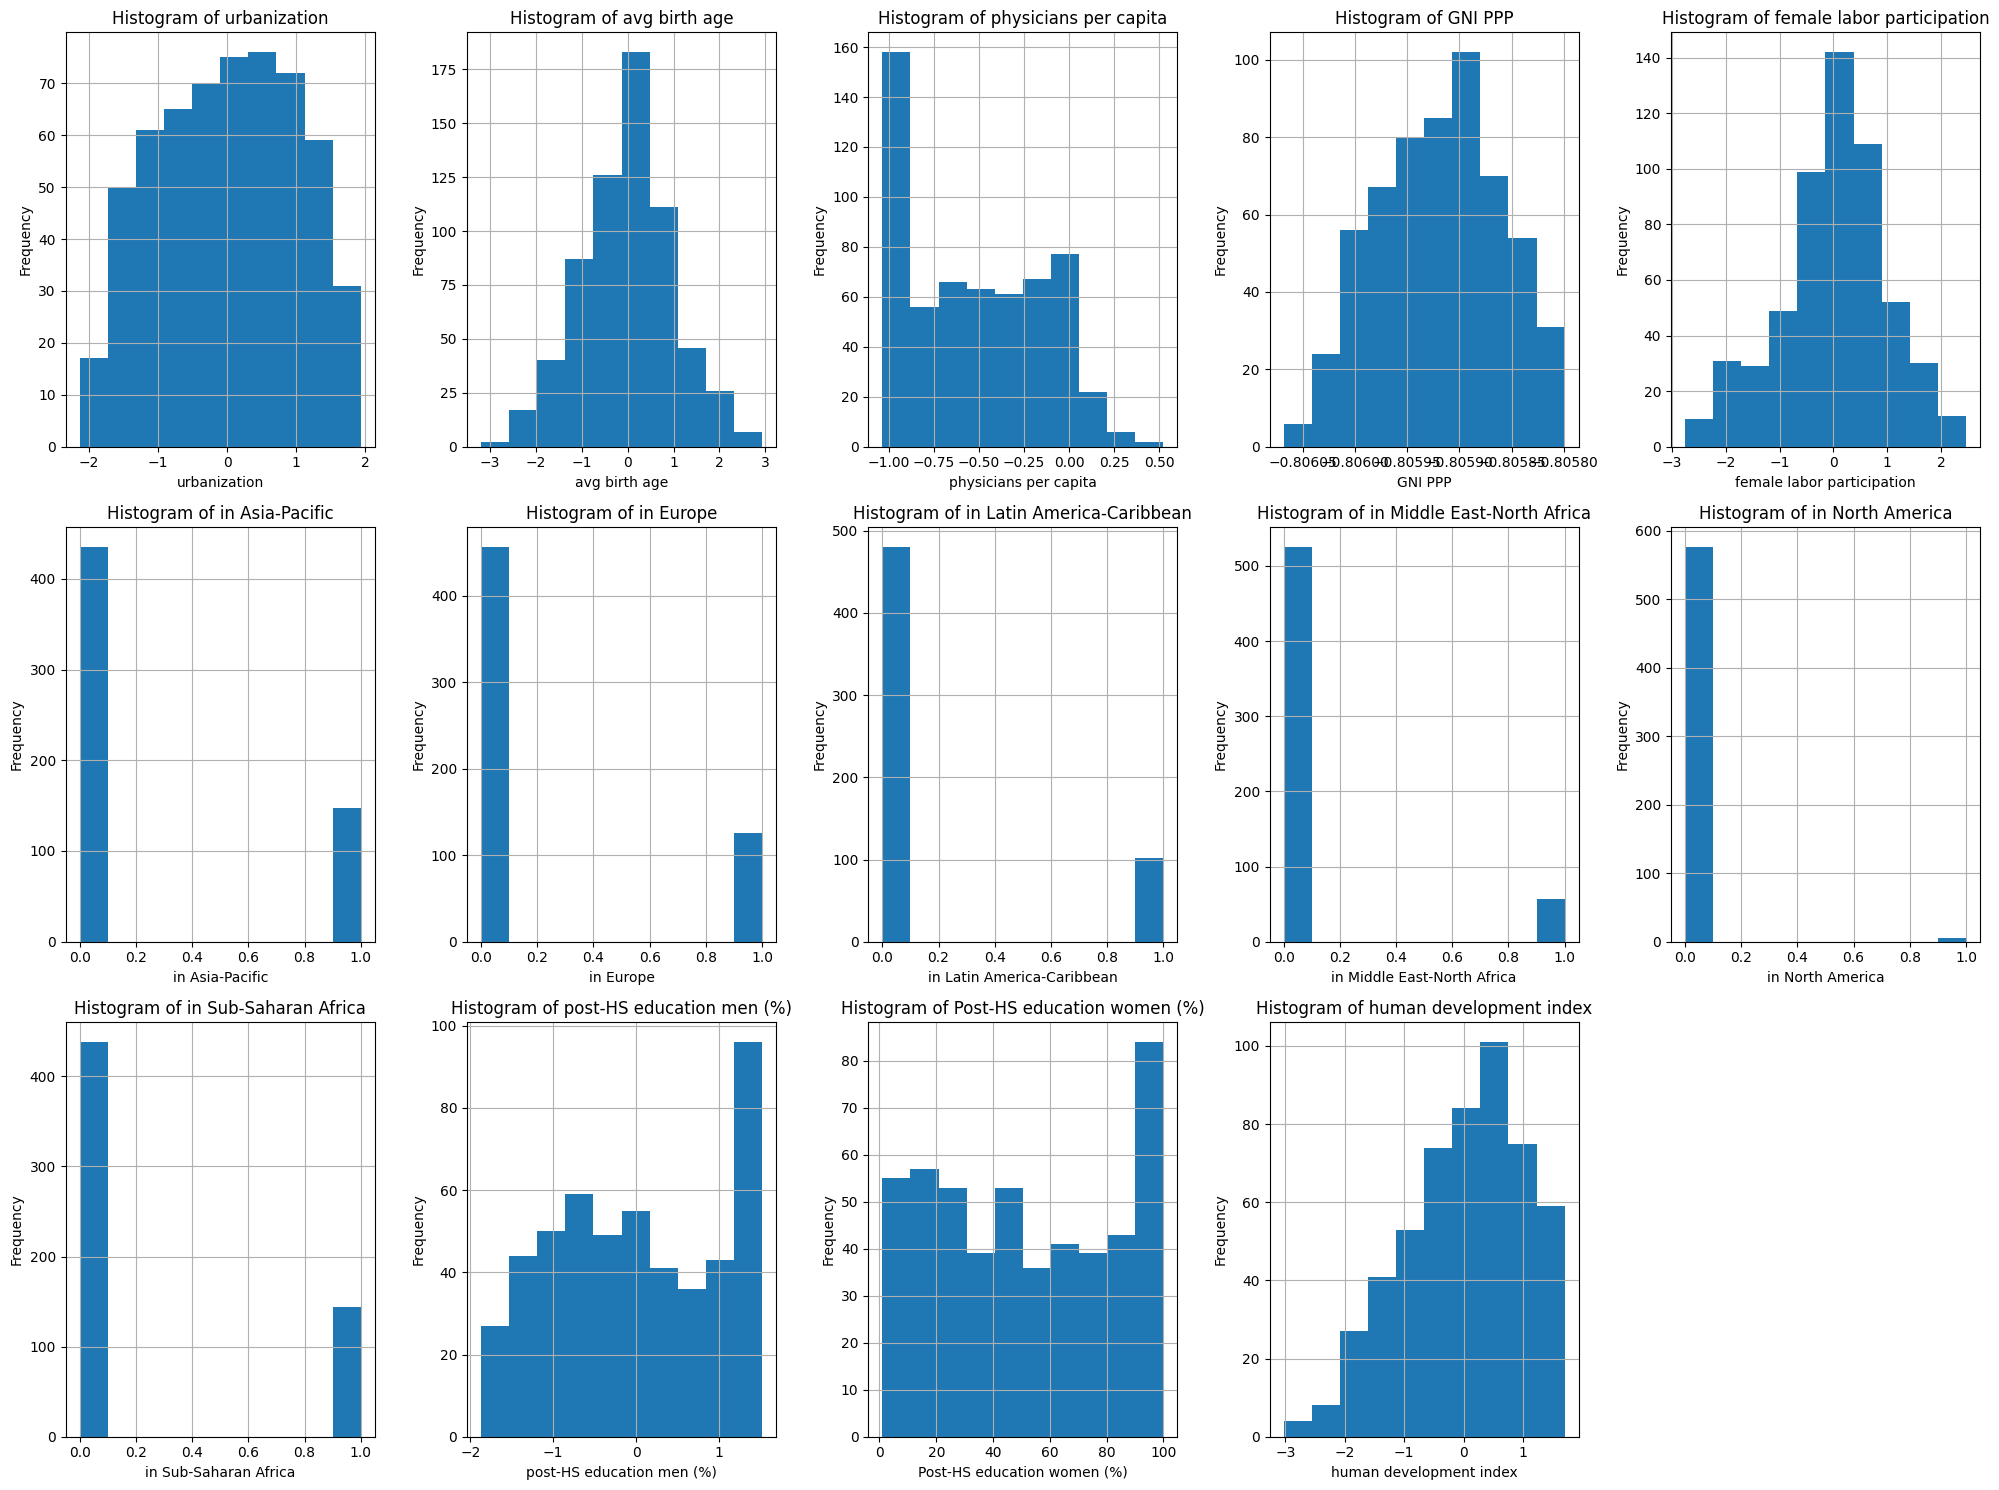

In [ ]:
def process_multi_year_data(data_output):
  years = [2023, 2007, 1991]
  all_features = []
  all_targets = []

  for year in years:
      df_features, target = calc_features_year(data, year)
      all_features.append(df_features)
      all_targets.extend(target)

  X = pd.concat(all_features)
  Y = pd.Series(all_targets, index=X.index, name='target')

  columns_to_drop = [
      'christians (%)', 'muslims (%)', 'no religion (%)', 'buddhists (%)',
      'hindus (%)', 'jews (%)', 'other religion (%)', 'gender inequality index',
      'happiness index', 'first marriage age women', 'first marriage age men',
      'work hours men', 'work hours women', 'social media users', 'abortion rate',
      'health expenditure' ,'maternity leave index'
  ]

  X = X.drop(columns=columns_to_drop)
  X = X.apply(pd.to_numeric, errors='coerce')

  # Add specific missing data points (structured by feature)
  missing_values_to_fill_manual = {
      'GNI PPP': {
          ('Venezuela, RB', 2023): 20017,
          ('Syrian Arab Republic', 2007): 3914.3,
          ('Nigeria', 2007): 3260.8,
          ('Afghanistan', 1991): 1070
      },
      'female labor participation': {
          ('Grenada', 2023): 51.42
      },
      'physicians per capita': {
          ('Hong Kong SAR, China', 2023): 2.1,
          ('Hong Kong SAR, China', 2007): 1.13,
          ('India', 2007): 0.61
      },
      'urbanization': {
          ('West Bank and Gaza', 2023): 77.58,
          ('West Bank and Gaza', 2007): 73.49,
          ('South Sudan', 2023): 21.56,
          ('Montenegro', 2023): 68.5,
          ('Montenegro', 2007): 63.14,
          ('Maldives', 2023): 42.41,
          ('Maldives', 2007): 35.2,
          ('Serbia', 2023): 57.11,
          ('Serbia', 2007): 54.33
      },
      'human development index': {
          ('Sudan', 2007): 0.526,
          ('Rwanda', 1991): 0.213,
          ('Sao Tome and Principe', 1991): 0.399,
          ('Liberia', 1991): 0.22,
          ('Ethiopia', 1991): 0.166
      }
  }

  for feature, country_year_values in missing_values_to_fill_manual.items():
      if feature in X.columns:
          for (country, year), value in country_year_values.items():
              if (country, year) in X.index:
                  X.loc[(country, year), feature] = value

  train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)
  return train_X, test_X, train_y, test_y
# Use ScalingMultiYear for transformation and scaling
scaler = ScalingMultiYear()
scaler.fit(X)
X_scaled = scaler.transform(X)


# Plot histograms of the scaled features
plot_features(X)
plot_features(X_scaled)


In [ ]:
class ScalingMultiYear(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['GNI PPP','physicians per capita']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','GNI PPP',
            'female labor participation','post-HS education men (%)',
            'post-HS education men (%)','human development index',
            'physicians per capita'
        ]
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [ ]:
# Filter for countries with unscaled GNI PPP less than 0
countries_with_low_gni = combined_df_features[combined_df_features['GNI PPP'] < 0]

# Print the countries and their GNI PPP values
print("Countries with unscaled GNI PPP smaller than 0:")
display(countries_with_low_gni[['GNI PPP']])

Countries with unscaled GNI PPP smaller than 0:


,,GNI PPP
country,year,
South Sudan,2023,-2266.666667


In [ ]:
find_missing_features(combined_df_features)

Countries with NaN values in their features:
[('American Samoa', 2023), ('Andorra', 2023), ('Antigua and Barbuda', 2023), ('Aruba', 2023), ('Bermuda', 2023), ('British Virgin Islands', 2023), ('Cayman Islands', 2023), ('Channel Islands', 2023), ('Cuba', 2023), ('Curacao', 2023), ('Dominica', 2023), ('Equatorial Guinea', 2023), ('Eritrea', 2023), ('Faroe Islands', 2023), ('French Polynesia', 2023), ('Gibraltar', 2023), ('Greenland', 2023), ('Grenada', 2023), ('Guam', 2023), ('Hong Kong SAR, China', 2023), ('Isle of Man', 2023), ('Kiribati', 2023), ("Korea, Dem. People's Rep.", 2023), ('Kosovo', 2023), ('Liechtenstein', 2023), ('Macao SAR, China', 2023), ('Maldives', 2023), ('Marshall Islands', 2023), ('Micronesia, Fed. Sts.', 2023), ('Monaco', 2023), ('Montenegro', 2023), ('Nauru', 2023), ('New Caledonia', 2023), ('Northern Mariana Islands', 2023), ('Palau', 2023), ('Puerto Rico (US)', 2023), ('San Marino', 2023), ('Serbia', 2023), ('Seychelles', 2023), ('Sint Maarten (Dutch part)', 202

In [ ]:

print(process_2023_data(init_process()))
"""
countries = sorted(list(set([key[0] for key in data.keys()])))
index=[(country, 2023) for country in countries]
for key in index:
  print(key in data)
"""

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

'\ncountries = sorted(list(set([key[0] for key in data.keys()])))\nindex=[(country, 2023) for country in countries]\nfor key in index:\n  print(key in data)\n'

In [45]:
    import dill

    filename = 'my_session.pkl'
    dill.dump_session(filename)

In [ ]:
    import dill

    filename = 'my_session.pkl'
    dill.load_session(filename)

In [ ]:
import dill

filename = 'my_session.pkl'
dill.load_session(filename)

In [ ]:
x_train, x_test, y_train,y_test=process_2023_data(data)

In [ ]:
print(x_test)

                          urbanization  avg birth age  happiness index  \
country             year                                                 
Ghana               2023     59.322040         29.506         4.289000   
Korea, Rep.         2023     86.335310         33.424         6.058000   
Congo, Rep.         2023     68.785110         28.562         5.221000   
Estonia             2023     73.768210         30.959         6.448000   
Sweden              2023     87.615330         31.575         7.344000   
Madagascar          2023     38.053696         27.869         4.228000   
United States       2023     85.785065         29.898         6.725000   
Honduras            2023     59.290665         27.227         5.968000   
Egypt, Arab Rep.    2023     51.379350         27.990         3.977000   
Benin               2023     50.171100         29.079         4.377000   
Malta               2023     88.736050         30.876         6.346000   
Chile               2023     91.913890

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assume X_train_2023, y_train_2023, X_test_2023, and Scaling2023 are defined in the environment

# Perform Lasso grid search for 2023 data
print('\nlasso regressor:')
scaler_2023 = Scaling2023()
lasso_gs_2023 = gridsearch_loocv_lasso(X_train_2023, y_train_2023, scaler_2023)
report_grid_search(lasso_gs_2023, X_train_2023, y_train_2023, 'lasso', scaler_2023)

# Get the best Lasso estimator for 2023 data
best_lasso_2023 = lasso_gs_2023.best_estimator_

# Filter X_test_2023 for 'Korea, Rep.'
# Ensure to use X_test_2023 which should be available after running y6r-hNMk6_9n
if ('Korea, Rep.', 2023) in X_test_2023.index:
    korea_rep_data = X_test_2023.loc[('Korea, Rep.', 2023)]

    # Convert the Series to a DataFrame with a single row and original column names
    korea_rep_data_df = pd.DataFrame([korea_rep_data], columns=X_test_2023.columns)

    # Predict using the best Lasso model
    predicted_target_korea_rep = best_lasso_2023.predict(korea_rep_data_df)

    print(f"\nPredicted target for Korea, Rep. (2023) using Lasso: {predicted_target_korea_rep[0]:.4f}")
else:
    print("\n'Korea, Rep.' for 2023 not found in X_test_2023.")


lasso regressor:
Best params: {'lasso__alpha': 0.02}
CV MSE: 0.3480 (±0.7681)

coefficients:
human development index: -0.5994
in Sub-Saharan Africa: 0.3986
social media users: -0.3733
gender inequality index: 0.1861
avg birth age: 0.1592
female labor participation: 0.1509
muslims (%): 0.1156
jews (%): 0.1134
first marriage age men: -0.1120
work hours women: -0.1042
hindus (%): -0.0547
healthcare index score: 0.0339
buddhists (%): -0.0319
no religion (%): 0.0311
other religion (%): 0.0055
maternity leave index: 0.0035
Post-HS education women (%): 0.0011
in Asia-Pacific: -0.0000
urbanization: 0.0000
happiness index: 0.0000
GNI PPP: -0.0000
christians (%): -0.0000
in Europe: -0.0000
in Latin America-Caribbean: -0.0000
in Middle East-North Africa: 0.0000
in North America: -0.0000
post-HS education men (%): 0.0000
first marriage age women: -0.0000
work hours men: -0.0000
abortion rate: 0.0000


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Assume best_lasso_2023, X_test_2023, and y_test_2023 are defined in the environment

countries_to_predict = ['Korea, Rep.', 'China', 'Japan', 'Sweden', 'Czechia']

print("Comparison of Predicted vs. Actual Target Values (Lasso - 2023 Data):")
print("-" * 60)

for country in countries_to_predict:
    if (country, 2023) in X_test_2023.index and (country, 2023) in y_test_2023.index:
        country_data = X_test_2023.loc[[(country, 2023)]] # Use double brackets to keep it as a DataFrame
        actual_target = y_test_2023.loc[(country, 2023)]

        # Predict using the best Lasso model
        predicted_target = best_lasso_2023.predict(country_data)

        print(f"{country}: Predicted = {predicted_target[0]:.4f}, Actual = {actual_target:.4f}")
    else:
        print(f"Data for '{country}' (2023) not found in test sets.")

print("-" * 60)

Comparison of Predicted vs. Actual Target Values (Lasso - 2023 Data):
------------------------------------------------------------
Korea, Rep.: Predicted = 0.9431, Actual = 0.7210
China: Predicted = 1.5210, Actual = 0.9990
Japan: Predicted = 1.3713, Actual = 1.2000
Sweden: Predicted = 1.2514, Actual = 1.4500
Czechia: Predicted = 1.3296, Actual = 1.4500
------------------------------------------------------------


In [ ]:
display(X_train_2023)

,,urbanization,avg birth age,happiness index,health expenditure,physicians per capita,GNI PPP,female labor participation,christians (%),muslims (%),no religion (%),...,Post-HS education women (%),human development index,gender inequality index,first marriage age women,first marriage age men,maternity leave index,work hours men,work hours women,abortion rate,social media users
country,year,,,,,,,,,,,,,,,,,,,,,
Malaysia,2023,76.783676,30.960,5.975,1280.890765,2.316,35360.0,51.573,9.153185,64.117195,0.844679,...,79.029999,0.819,0.172,31.0,30.2,14.0000,45.31,43.35,11.0,0.797158
"Gambia, The",2023,41.470592,29.823,4.485,88.690523,0.102,3220.0,45.242,2.893368,97.002708,0.017932,...,35.504486,0.524,0.578,30.7,26.7,12.0000,44.09,31.11,16.0,0.143156
Albania,2023,61.257164,29.132,5.304,1186.215336,1.883,20990.0,53.207,17.815659,74.507225,7.652887,...,90.499878,0.810,0.107,30.9,29.4,23.2300,43.26,39.07,1.2,0.552046
Benin,2023,50.171100,29.079,4.377,105.518782,0.195,4090.0,74.183,53.231159,31.401228,4.885910,...,7.217570,0.515,0.573,24.4,22.2,14.0000,43.80,41.17,32.0,0.145128
Eswatini,2023,27.941381,27.891,3.502,761.853341,1.591,10560.0,44.886,93.228432,0.135700,6.155977,...,45.820789,0.695,0.484,30.5,28.5,0.0000,43.38,38.71,29.0,0.326628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Latvia,2023,71.988180,30.317,6.234,3139.066911,3.377,40510.0,55.383,77.267601,0.670409,16.973822,...,97.205177,0.889,0.117,32.7,31.7,10.2400,36.67,33.23,6.4,0.787673
Rwanda,2023,24.698296,30.590,3.268,222.124218,0.116,3330.0,58.044,97.033600,1.807574,1.007935,...,20.517868,0.578,0.394,24.7,22.7,5.3868,32.65,27.93,28.0,0.063860
Bolivia,2023,71.371340,28.144,5.784,830.752592,1.269,10620.0,71.909,88.925598,0.009802,9.547658,...,57.391281,0.733,0.419,26.6,25.4,4.1160,40.98,34.17,38.0,0.600073


In [ ]:
import pandas as pd

# Provided data
data = {
    'מאפיינים/מטרה': [
        'מספר ילדים לאישה',
        'גיל חתונה ראשונה גבר',
        'גיל חתונה ראשונה אישה',
        'אחוז אוכלוסיה הגר בעיר',
        'גיל נשים ממוצע בלידה',
        'הכנסה לנפש בכוח קניה $2021',
        'רופאים לנפש',
        'הוצאות רפואה לנפש בכוח קניה',
        'מדד חופשת הלידה',
        'פעילות ברשתות חברתיות',
        'הפלות ל1000 נשים בגיל פוריות בשנה',
        'מדד האושר',
        'השתתפות נשים בעבודה',
        'שעות עבודה ממוצעות גברים',
        'שעות עבודה ממוצעות נשים',
        'השכלה על תיכונית נשים',
        'השכלה על תיכונית גברים',
        'רמת פיתוח אנושית((hdi',
        'אי שיוון מגדרי ((gii',
        'אחוז יהודים',
        'אחוז מוסלמים',
        'אחוז נוצרים',
        'אחוז בודהיסטים',
        'אחוז הינדים',
        'אחוז חסרי דת',
        'אחוז בעלי דת אחרת',
        'במזרח התיכון/צפון אפריקה',
        'באירופה',
        'בצפון אמריקה',
        'באפריקה שמדרום לסהרה',
        'באמריקה הלטינית ובקריביים',
        'באזור אסיה והאוקיינוס השקט',
    ],
    'חרדים': [
        6.4, 23, 22, 91.53, 31.3, 29213, 3.713, 4008, 14, 0.32, 8.1, 7.341, 81, 36.5, 32.5, 14, 4.2, 0.847, 0.525, 100, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0
    ],
    'יהודים לא חרדים': [
        2.5, 30, 28, 74.26, 31.3, 51498, 3.713, 4008, 14, 0.911, 8.1, 7.341, 83, 45, 38.5, 45.1, 31.3, 0.959, 0.043, 100, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0
    ],
    'ערבים': [
        2.75, 26.96, 23.11, 42.5, 27.7, 29420, 3.713, 4008, 14, 0.7128, 5.99, 7.341, 33.7, 43.4, 36.5, 23.3, 10.8, 0.856, 0.237, 0, 100, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Transpose the DataFrame so that the first column becomes the index and the other columns become rows
df_transposed = df.set_index('מאפיינים/מטרה').T

# Rename columns to English
english_column_names = {
    'מספר ילדים לאישה': 'target',
    'גיל חתונה ראשונה גבר': 'first marriage age men',
    'גיל חתונה ראשונה אישה': 'first marriage age women',
    'אחוז אוכלוסיה הגר בעיר': 'urbanization',
    'גיל נשים ממוצע בלידה': 'avg birth age',
    'הכנסה לנפש בכוח קניה $2021': 'GNI PPP',
    'רופאים לנפש': 'physicians per capita',
    'הוצאות רפואה לנפש בכוח קניה': 'health expenditure',
    'מדד חופשת הלידה': 'maternity leave index', # Added English name mapping
    'פעילות ברשתות חברתיות': 'social media users',
    'הפלות ל1000 נשים בגיל פוריות בשנה': 'abortion rate',
    'מדד האושר': 'happiness index',
    'השתתפות נשים בעבודה': 'female labor participation',
    'שעות עבודה ממוצעות גברים': 'work hours men',
    'שעות עבודה ממוצעות נשים': 'work hours women',
    'השכלה על תיכונית נשים': 'Post-HS education women (%)',
    'השכלה על תיכונית גברים': 'post-HS education men (%)',
    'רמת פיתוח אנושית((hdi': 'human development index',
    'אי שיוון מגדרי ((gii': 'gender inequality index',
    'אחוז יהודים': 'jews (%)',
    'אחוז מוסלמים': 'muslims (%)',
    'אחוז נוצרים': 'christians (%)',
    'אחוז בודהיסטים': 'buddhists (%)',
    'אחוז הינדים': 'hindus (%)',
    'אחוז חסרי דת': 'no religion (%)',
    'אחוז בעלי דת אחרת': 'other religion (%)',
    'במזרח התיכון/צפון אפריקה': 'in Middle East-North Africa',
    'באירופה': 'in Europe',
    'בצפון אמריקה': 'in North America',
    'באפריקה שמדרום לסהרה': 'in Sub-Saharan Africa',
    'באמריקה הלטינית ובקריביים': 'in Latin America-Caribbean',
    'באזור אסיה והאוקיינוס השקט': 'in Asia-Pacific',
}

df_english = df_transposed.rename(columns=english_column_names)

# Handle duplicate column names if they exist (e.g., 'in North America')
# Keep the first occurrence and drop subsequent duplicates
df_english = df_english.loc[:,~df_english.columns.duplicated()]

# Separate the target variable
target_df = df_english[['target']]
features_df = df_english.drop(columns=['target'])

# Display the new DataFrames
print("Features DataFrame:")
display(features_df)

print("\nTarget DataFrame:")
display(target_df)

Features DataFrame:


מאפיינים/מטרה,first marriage age men,first marriage age women,urbanization,avg birth age,GNI PPP,physicians per capita,health expenditure,maternity leave index,social media users,abortion rate,happiness index,female labor participation,work hours men,work hours women,Post-HS education women (%),post-HS education men (%),human development index,gender inequality index,jews (%),muslims (%),christians (%),buddhists (%),hindus (%),no religion (%),other religion (%),in Middle East-North Africa,in Europe,in North America,in Sub-Saharan Africa,in Latin America-Caribbean,in Asia-Pacific
חרדים,23.00,22.00,91.53,31.3,29213.0,3.713,4008.0,14.0,0.3200,8.10,7.341,81.0,36.5,32.5,14.0,4.2,0.847,0.525,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
יהודים לא חרדים,30.00,28.00,74.26,31.3,51498.0,3.713,4008.0,14.0,0.9110,8.10,7.341,83.0,45.0,38.5,45.1,31.3,0.959,0.043,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ערבים,26.96,23.11,42.50,27.7,29420.0,3.713,4008.0,14.0,0.7128,5.99,7.341,33.7,43.4,36.5,23.3,10.8,0.856,0.237,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0



Target DataFrame:


מאפיינים/מטרה,target
חרדים,6.40
יהודים לא חרדים,2.50
ערבים,2.75


In [ ]:
# Filter out Israel from the 2023 training data
X_train_2023_no_israel = X_train_2023.drop(index=('Israel', 2023), errors='ignore')
y_train_2023_no_israel = y_train_2023.drop(index=('Israel', 2023), errors='ignore')

# Initialize the scaler for 2023 data
scaler_2023_no_israel = Scaling2023()

# Retrain Lasso on the data without Israel
print('Lasso regressor (excluding Israel):')
lasso_gs_2023_no_israel = gridsearch_loocv_lasso(X_train_2023_no_israel, y_train_2023_no_israel, scaler_2023_no_israel)
report_grid_search(lasso_gs_2023_no_israel, X_train_2023_no_israel, 'lasso', scaler_2023_no_israel)

# Retrain Ridge on the data without Israel
print('\nRidge regressor (excluding Israel):')
# Assuming you have a gridsearch_ridge_loocv function defined, similar to the others
# If not, I can generate it. For now, I'll assume it exists.
# If it doesn't exist, the execution will fail, and I'll generate it in the next step.
ridge_gs_2023_no_israel = gridsearch_ridge_loocv(X_train_2023_no_israel, y_train_2023_no_israel, scaler_2023_no_israel)
report_grid_search(ridge_gs_2023_no_israel, X_train_2023_no_israel, 'ridge', scaler_2023_no_israel)

Lasso regressor (excluding Israel):
Best params: {'lasso__alpha': np.float64(0.004281332398719396)}
CV MSE: 0.2616 (±0.4805)

coefficients:
human development index: -0.8269
in Sub-Saharan Africa: 0.7448
in Middle East-North Africa: 0.3803
social media users: -0.3492
post-HS education men (%): 0.3278
gender inequality index: 0.2136
healthcare index score: 0.2054
happiness index: 0.1842
first marriage age women: -0.1519
avg birth age: 0.1329
work hours men: -0.1149
urbanization: 0.1133
muslims (%): 0.1011
abortion rate: 0.0695
other religion (%): -0.0443
no religion (%): 0.0393
female labor participation: 0.0346
buddhists (%): -0.0316
hindus (%): -0.0229
in Europe: -0.0161
jews (%): -0.0114
Post-HS education women (%): -0.0077
maternity leave index: -0.0049
work hours women: 0.0003
GNI PPP: 0.0000
christians (%): -0.0000
in Asia-Pacific: -0.0000
in North America: -0.0000
in Latin America-Caribbean: -0.0000
first marriage age men: -0.0000

Ridge regressor (excluding Israel):


NameError: name 'gridsearch_ridge_loocv' is not defined

In [ ]:
# Ensure the new features_df has the same columns as X_train_2023 in the same order
# This is crucial for correct prediction with the trained models and scalers.
# We will reindex features_df to match the columns of X_train_2023.
features_df_reindexed = features_df.reindex(columns=X_train_2023.columns)

# Apply the same scaling as used for the 2023 training data
# Assuming scaler_2023 was defined and fitted during the 2023 data analysis
# If not, we would need to re-initialize and fit it on X_train_2023
# For now, we assume it's available from the previous execution.
# If not, the code will fail, and we can address it then.

# Create a scaler instance and fit it to the original 2023 training data
# This ensures the new data is scaled using the same parameters
scaler_2023_predict = Scaling2023()
scaler_2023_predict.fit(X_train_2023)

# Transform the new features data
features_df_scaled = scaler_2023_predict.transform(features_df_reindexed)


print("Predictions for the new data using trained 2023 regressors:")
print("-" * 60)

# Predict using each of the trained regressors (assuming they are available from previous runs)
# lasso_gs_2023, elastic_net_gs_2023, rf_gs_2023, xgb_gs_2023

regressors_2023 = {
    "Lasso": lasso_gs_2023.best_estimator_,
    "Ridge": ridge_gs_2023.best_estimator_,
    "Random Forest": rf_gs_2023.best_estimator_,
    "XGBoost": xgb_gs_2023.best_estimator_
}

for name, estimator in regressors_2023.items():
    # Predict on the scaled new features
    # Note: The estimators within the pipeline handle the scaling internally
    # So we use the original features_df_reindexed here, as the pipeline expects unscaled data.
    predicted_target = estimator.predict(features_df_reindexed)

    print(f"{name} Predictions:")
    for index, prediction in zip(features_df_reindexed.index, predicted_target):
        print(f"  {index}: {prediction:.4f}")
    print("-" * 20)

# Compare with actual target values
print("\nActual Target Values:")
print("-" * 60)
display(target_df)
print("-" * 60)

Predictions for the new data using trained 2023 regressors:
------------------------------------------------------------
Lasso Predictions:
  חרדים: 4.2204
  יהודים לא חרדים: 2.0559
  ערבים: 1.8761
--------------------
Ridge Predictions:
  חרדים: 4.6693
  יהודים לא חרדים: 2.5847
  ערבים: 2.0082
--------------------
Random Forest Predictions:
  חרדים: 2.1979
  יהודים לא חרדים: 2.1377
  ערבים: 2.1331
--------------------
XGBoost Predictions:
  חרדים: 2.8626
  יהודים לא חרדים: 2.3570
  ערבים: 2.1947
--------------------

Actual Target Values:
------------------------------------------------------------


מאפיינים/מטרה,target
חרדים,6.40
יהודים לא חרדים,2.50
ערבים,2.75


------------------------------------------------------------
